# Problem Definition

Use historical boxscores to predict an NBA player's Rebounds Per Second (RPS) in a single game. In conjunction with the predicted NBA player's Seconds Played (SP) will be used to predict the total rebounds of a player in a single game.

### Usage

- The final rebounds projection will be used along other stat projections to predict a player's Daily Fantasy Sports (DFS) Fantasy Score. 
- The projection will also be used to bet on vegas lines.

# Setup

Import the necessary libraries

In [1]:
# for data
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from pyNBA.Data.data import QueryData
from pyNBA.Models.helpers import CleanData
import math

# for features
from pyNBA.Models.features import FeatureCreation
from pyNBA.Models.cluster import Cluster, Evaluate
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFE

# for plotting
import matplotlib.pyplot as plt
import seaborn as sns
from research import Helpers
from statsmodels.graphics.api import abline_plot

# for statistical tests
from scipy.stats import shapiro
import pingouin as pg

# for machine learning
from sklearn import model_selection, preprocessing, ensemble, neighbors, linear_model, svm, neural_network, metrics
import xgboost as xgb
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

# for explainer
from lime import lime_tabular

# misc
import warnings
warnings.filterwarnings('ignore')
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

/Users/brandonshimiaie/.virtualenvs/nbavenv/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.3, the latest is 0.3.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


# Factor Determination
Determine the factors that influence a player's Rebounds Per Second (RPS).

- Historical RPS
    - DRPS/ORPS
    - DR%/OR%
    - Season averages
    - Recent performances
    - Home vs. Away
    - Start vs. Bench
    - Rest


- Position


- Defense
    - Opponent FG%
    - Opponent RPS Allowed
        - ORPS, DRPS, OR%, DR%
        - Starters vs. Bench Players
        - By position
    - Vegas implied total points


- Injuries
    - RPS of players playing vs avg RPS of team
    - Player RPS by starting lineup/ active high rebounding players
        - DRPS/ORPS
        - DR%/OR%

# Data Analysis
Summarize the characteristics of the dataset.

First, I will pull the boxscore data and drop the unessesary rows.

In [2]:
query_data = QueryData()
clean_data = CleanData()

# pull boxscore data
boxscores = query_data.query_boxscore_data()

# we are only interested in the boxscores of healthy and non-resting players
boxscores = clean_data.drop_rows_player_injured(boxscores)
boxscores = clean_data.drop_rows_player_rest(boxscores)

pd.set_option('display.max_columns', None)
display(boxscores.head())

/Users/brandonshimiaie/Projects/sqlite/db/nba.db
2.6.0


,PLAYERID,TEAM,GAMEID,OPP_TEAM,COMMENT,START,SECONDSPLAYED,PTS,FGM,FGA,FG3M,FG3A,FTM,FTA,PTS_OFF_TOV,PTS_2ND_CHANCE,PTS_FB,PTS_PAINT,PCT_AST_2PM,PCT_AST_3PM,OREB,OREB_PCT,DREB,DREB_PCT,AST,AST_PCT,AST_RATIO,STL,BLK,TOV,PF,PLUSMINUS,USG_PCT,PACE,ID_x,SEASON,DATE,HTM,VTM,W,ID_y,NAME,POSITION,SCHOOL,COUNTRY,HEIGHT,WEIGHT,DRAFTYEAR,DRAFTROUND,DRAFTNUMBER,BIRTHDATE
0,203906,ORL,0021400001,NOP,,0,179,4,2,2,0,0,0,2,0,0,2,4,0.500,0.0,0,0.000,1.0,0.333,0,0.000,0.0,0,0,0,1,4,0.300,112.63,0021400001,2014-15,2014-10-28,NOP,ORL,ORL,203906,Devyn Marble,Forward,Iowa,USA,78,200,2014,2,56,1992-09-21
1,2584,ORL,0021400001,NOP,,0,247,0,0,1,0,0,0,0,0,0,0,0,0.000,0.0,1,0.250,1.0,0.100,0,0.000,0.0,0,0,0,0,-3,0.100,93.28,0021400001,2014-15,2014-10-28,NOP,ORL,ORL,2584,Willie Green,Guard,Detroit Mercy,USA,75,205,2003,2,41,1981-07-28
2,202690,NOP,0021400001,ORL,,0,1068,2,0,6,0,3,2,2,0,0,0,0,0.000,0.0,0,0.000,0.0,0.000,2,0.133,22.2,1,0,0,3,3,0.146,98.43,0021400001,2014-15,2014-10-28,NOP,ORL,ORL,202690,Jimmer Fredette,Guard,Brigham Young,USA,74,195,2011,1,10,1989-02-25
3,202699,ORL,0021400001,NOP,,1,2192,25,9,18,1,2,6,6,6,5,8,16,0.625,1.0,2,0.048,6.0,0.111,0,0.000,0.0,1,0,4,2,-4,0.289,93.28,0021400001,2014-15,2014-10-28,NOP,ORL,ORL,202699,Tobias Harris,Forward,Tennessee,USA,80,226,2011,1,19,1992-07-15
4,201950,NOP,0021400001,ORL,,1,1622,8,4,11,0,3,0,0,2,2,2,6,0.250,0.0,0,0.000,2.0,0.067,4,0.190,23.5,3,1,2,2,9,0.188,94.99,0021400001,2014-15,2014-10-28,NOP,ORL,ORL,201950,Jrue Holiday,Guard,UCLA,USA,75,205,2009,1,17,1990-06-12


I need to determine the type of each column, as well as the proportion of missing data.

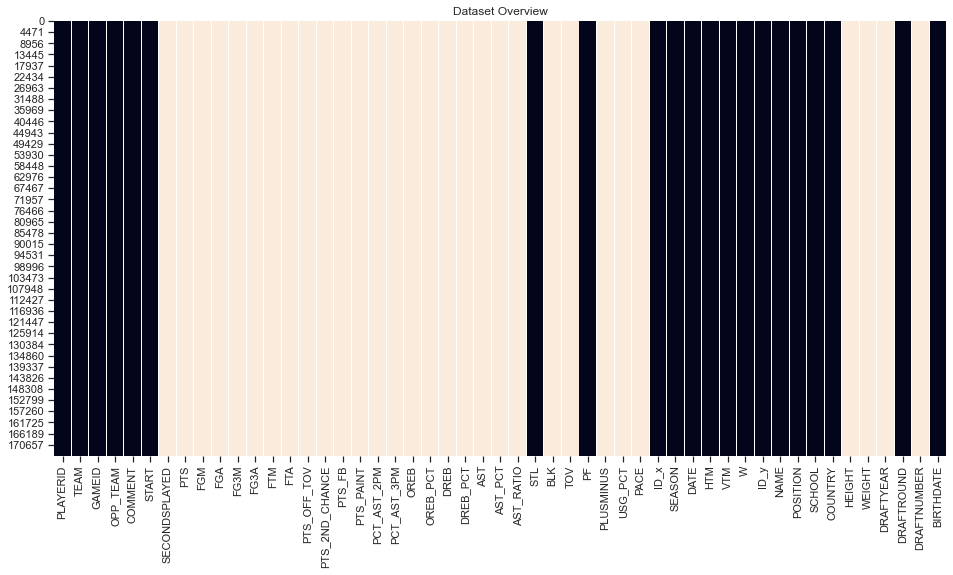

 Categerocial   Numeric   NaN 

Percentage of rows containing at least one missing value: 0.0


In [3]:
helpers = Helpers()

plt.rcParams["figure.figsize"] = (16, 8)
helpers.visualize_dataframe(boxscores)

Great, there is no missing data.

Next I will create the column of our dependant variable, $RPS$.

In [4]:
boxscores['REB'] = boxscores['DREB'] + boxscores['OREB']

y = 'Y'
boxscores[y] = boxscores['REB']/boxscores['SECONDSPLAYED']

Let's take a look at the distribution of values of our dependant variable. I will use a histogram to to visualize the probability density distribution of the outcomes of $Y$, and a box plot to graph data groups and outliers.

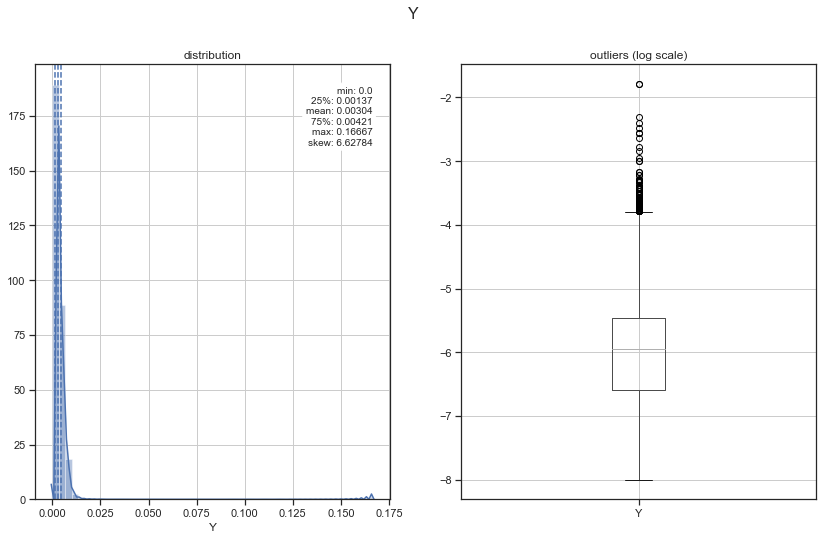

In [5]:
helpers.visualize_variable_distribution(boxscores, y, figsize=(14, 8))

Yikes.

There is clearly an abundance of outliers on the right side of the distribution.

My first guess of the cause of the plethora of outliers is that those outliers come from boxscores in which the player played very few seconds. For example, if a player played for 6 seconds, and collected 1 rebound, his $RPS$ would be 0.167. That would be an outlier in our distribtion.

Below shows the $RPS$ distribution across different playing times.

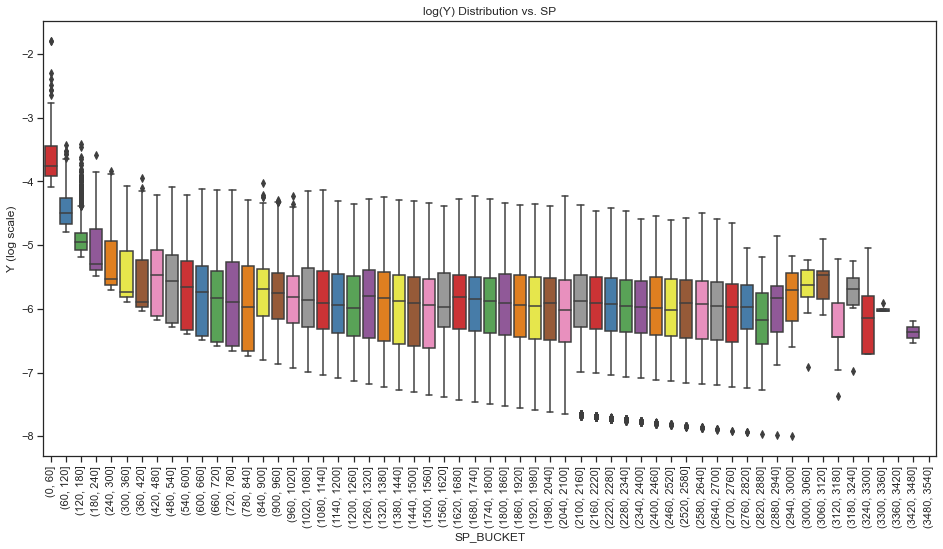

In [6]:
sp_max = boxscores['SECONDSPLAYED'].max()
max_bucket = int(60 * round(float(sp_max)/60))
buckets = [i for i in range(0, max_bucket, 60)]

temp = boxscores[[y, 'SECONDSPLAYED']]
temp['Y (log scale)'] = temp[y].apply(lambda x: np.log(x) if x > 0 else np.nan)
temp['SP_BUCKET'] = pd.cut(temp['SECONDSPLAYED'], buckets)

ax = sns.boxplot(x="SP_BUCKET", y="Y (log scale)", data=temp, palette="Set1")
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.title.set_text('log(Y) Distribution vs. SP')
plt.show()
plt.close()

It seems as though the outliers are coming from the (0, 60] seconds played bucket. Let's remove those values from our set of outcomes, and replot the distributions.

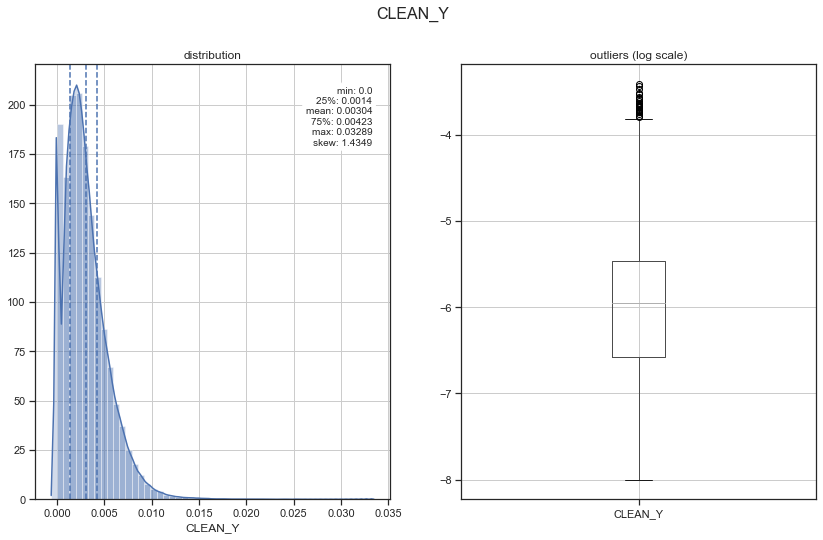

In [7]:
sp_threshold = 60

clean_y = 'CLEAN_Y'
boxscores[clean_y] = boxscores[y]
boxscores.loc[boxscores['SECONDSPLAYED'] <= sp_threshold, clean_y] = np.nan
helpers.visualize_variable_distribution(boxscores, clean_y, figsize=(14, 8))

This distribution looks better. We have far less positive outliers.

However, the distribution is still very skewed right and contains many outliers much higher than our mean.

Let's try looking at the distribtion of log outcomes.

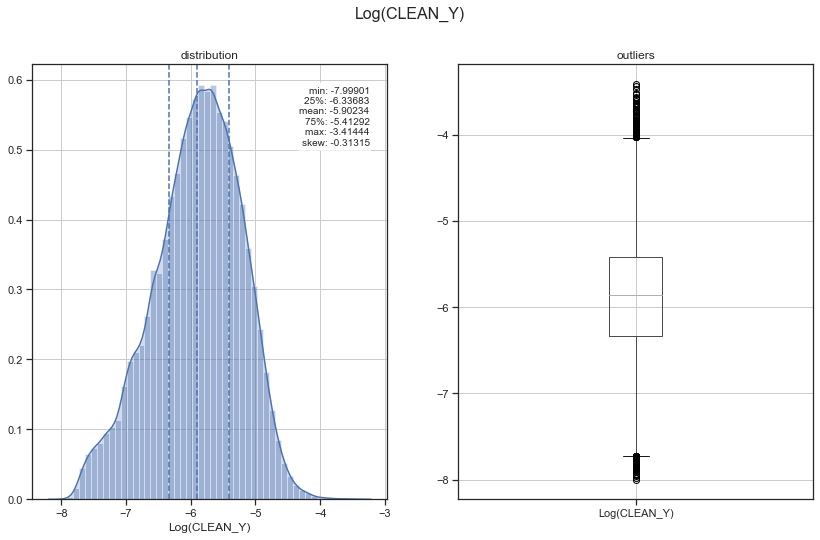

In [8]:
boxscores['Log(CLEAN_Y)'] = np.log(boxscores[clean_y])
boxscores['Log(CLEAN_Y)'] = boxscores['Log(CLEAN_Y)'].replace(-np.inf, np.nan)

helpers.visualize_variable_distribution(boxscores, 'Log(CLEAN_Y)', log_boxplot=False, figsize=(14, 8))

In [9]:
stat, p = shapiro(boxscores['Log(CLEAN_Y)'].dropna())
print(stat, p)

0.9907309412956238 0.0


Much better.

The distribution now contains a roughly equal amount of outliers on the left and right side, is less skewed, and is statistically normal.

# Feature Engineering
Create new features from raw data using domain knowlege.

In [10]:
regressors = []
categorical_regressors = []

### Historical RPS
First, I will create features that represent a player's historical $RPS$.

I will start by calculating the running $DRPS$ and $ORPS$ of a player in a season.

In [11]:
feature_creation = FeatureCreation()

boxscores['ORPS'] = boxscores['OREB']/boxscores['SECONDSPLAYED']
boxscores['DRPS'] = boxscores['DREB']/boxscores['SECONDSPLAYED']

boxscores = feature_creation.expanding_weighted_mean(
    df=boxscores, group_col_names=['SEASON', 'TEAM', 'PLAYERID'], col_name='DRPS', weight_col_name='SECONDSPLAYED',
    new_col_name='AVG_DRPS'
)

boxscores = feature_creation.expanding_weighted_mean(
    df=boxscores, group_col_names=['SEASON', 'TEAM', 'PLAYERID'], col_name='ORPS', weight_col_name='SECONDSPLAYED',
    new_col_name='AVG_ORPS'
)

regressors.append('AVG_DRPS')
regressors.append('AVG_ORPS')

Next, I will calculate the average $RPS$ of a player in the previous games against the same opposing team in the same season.

In [12]:
boxscores = feature_creation.expanding_weighted_mean(
    df=boxscores, group_col_names=['SEASON', 'TEAM', 'OPP_TEAM', 'PLAYERID'], col_name=y, weight_col_name='SECONDSPLAYED',
    new_col_name='AVG_Y_OPP_TEAM'
)

regressors.append('AVG_Y_OPP_TEAM')

Do more recent rebounding performances within a season matter more than previous ones?

To answer this, first I will calculate the Autocorrelation between a player's $DRPS$ ($ORPS$) and his previous $DRPS$ ($ORPS$) values:

$$ ACF(X_{0}, X_{i}) $$ <br>

Then, I will calculate the Partial Autocorrelation between between a player's $DRPS$ ($ORPS$) and his previous $DRPS$ ($ORPS$) values, using the lags in between as covariates:

$$ PACF(X_{0}, X_{i}  |  \{X_{j}\}_{0<j<i}) $$ <br>

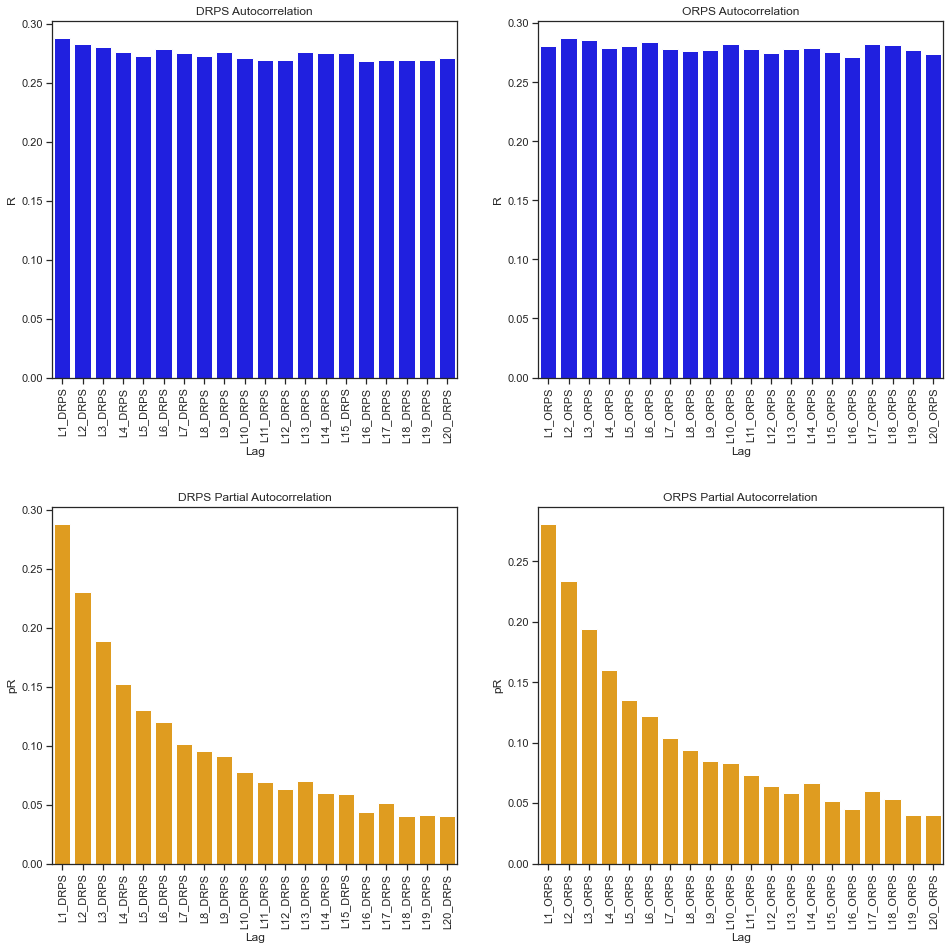

In [13]:
boxscores['CLEAN_DRPS'] = boxscores['DRPS']
boxscores.loc[boxscores['SECONDSPLAYED'] <= sp_threshold, 'CLEAN_DRPS'] = np.nan

boxscores['CLEAN_ORPS'] = boxscores['ORPS']
boxscores.loc[boxscores['SECONDSPLAYED'] <= sp_threshold, 'CLEAN_ORPS'] = np.nan

dreb_x_ticks = []
dreb_corrs = []
dreb_p_corrs = []

oreb_x_ticks = []
oreb_corrs = []
oreb_p_corrs = []
for i in range(1, 21):
    x = 'L{}_DRPS'.format(str(i))

    boxscores = feature_creation.lag(
        df=boxscores, group_col_names=['SEASON', 'TEAM', 'PLAYERID'], col_name='CLEAN_DRPS', new_col_name=x, n_shift=i
    )
    
    corr = boxscores['CLEAN_DRPS'].corr(boxscores[x])
    p_corr = pg.partial_corr(data=boxscores, x=x, y='CLEAN_DRPS', covar=dreb_x_ticks)
    
    dreb_corrs.append(corr)
    dreb_p_corrs.append(p_corr['r'][0])
    dreb_x_ticks.append(x)
    
    x = 'L{}_ORPS'.format(str(i))
    
    boxscores = feature_creation.lag(
        df=boxscores, group_col_names=['SEASON', 'TEAM', 'PLAYERID'], col_name='CLEAN_ORPS', new_col_name=x, n_shift=i
    )
    
    corr = boxscores['CLEAN_ORPS'].corr(boxscores[x])
    p_corr = pg.partial_corr(data=boxscores, x=x, y='CLEAN_ORPS', covar=oreb_x_ticks)
    
    oreb_corrs.append(corr)
    oreb_p_corrs.append(p_corr['r'][0])
    
    oreb_x_ticks.append(x)
    
fig, ax = plt.subplots(nrows=2, ncols=2, sharex=False, sharey=False, figsize=(14, 14))

dreb_corr_df = pd.DataFrame({'R': dreb_corrs, 'pR': dreb_p_corrs, 'Lag': dreb_x_ticks})
sns.barplot(x='Lag', y='R', data=dreb_corr_df, color='blue', ax=ax.flatten()[0])
ax.flatten()[0].set_xticklabels(ax.flatten()[0].get_xticklabels(),rotation=90)
ax.flatten()[0].title.set_text('DRPS Autocorrelation')

sns.barplot(x='Lag', y='pR', data=dreb_corr_df, color='orange', ax=ax.flatten()[2])
ax.flatten()[2].set_xticklabels(ax.flatten()[2].get_xticklabels(),rotation=90)
ax.flatten()[2].title.set_text('DRPS Partial Autocorrelation')

oreb_corr_df = pd.DataFrame({'R': oreb_corrs, 'pR': oreb_p_corrs, 'Lag': oreb_x_ticks})

sns.barplot(x='Lag', y='R', data=oreb_corr_df, color='blue', ax=ax.flatten()[1])
ax.flatten()[1].set_xticklabels(ax.flatten()[1].get_xticklabels(),rotation=90)
ax.flatten()[1].title.set_text('ORPS Autocorrelation')

sns.barplot(x='Lag', y='pR', data=oreb_corr_df, color='orange', ax=ax.flatten()[3])
ax.flatten()[3].set_xticklabels(ax.flatten()[3].get_xticklabels(),rotation=90)
ax.flatten()[3].title.set_text('ORPS Partial Autocorrelation')

fig.tight_layout(pad=3.0)
plt.show()
plt.close()

While the Autocorrelaton of each between $DREB$ ($OREB$) and each $DREB_{i}$ ($OREB_{i}$) is similar, the Partial Autocorrelations exponentially decrease. This tells us that each $X_{i}$ tells us less new information than the preceding lag does. This is a reason for us to add the first lags to our list of regressors. It also makes the case that an exponentially weighted mean of previous lags may be more predictive than a normal mean.

In [14]:
regressors.append('L1_DRPS')
regressors.append('L1_ORPS')

boxscores = feature_creation.expanding_ewm(
    df=boxscores, group_col_names=['SEASON', 'TEAM', 'PLAYERID'], col_name='DRPS', new_col_name='EWM_DRPS', alpha=0.90
)
boxscores = feature_creation.expanding_ewm(
    df=boxscores, group_col_names=['SEASON', 'TEAM', 'PLAYERID'], col_name='ORPS', new_col_name='EWM_ORPS', alpha=0.90
)

regressors.append('EWM_DRPS')
regressors.append('EWM_ORPS')

Next, I will calculate the partial correlation between $DREB$ ($OREB$) and previous moveing averages of $DREB$ ($OREB$), using a covariate of the AVG_$DREB$ (AVG_$OREB$). The peak of this graph will tell us which MA provides the most new information on top of the average.

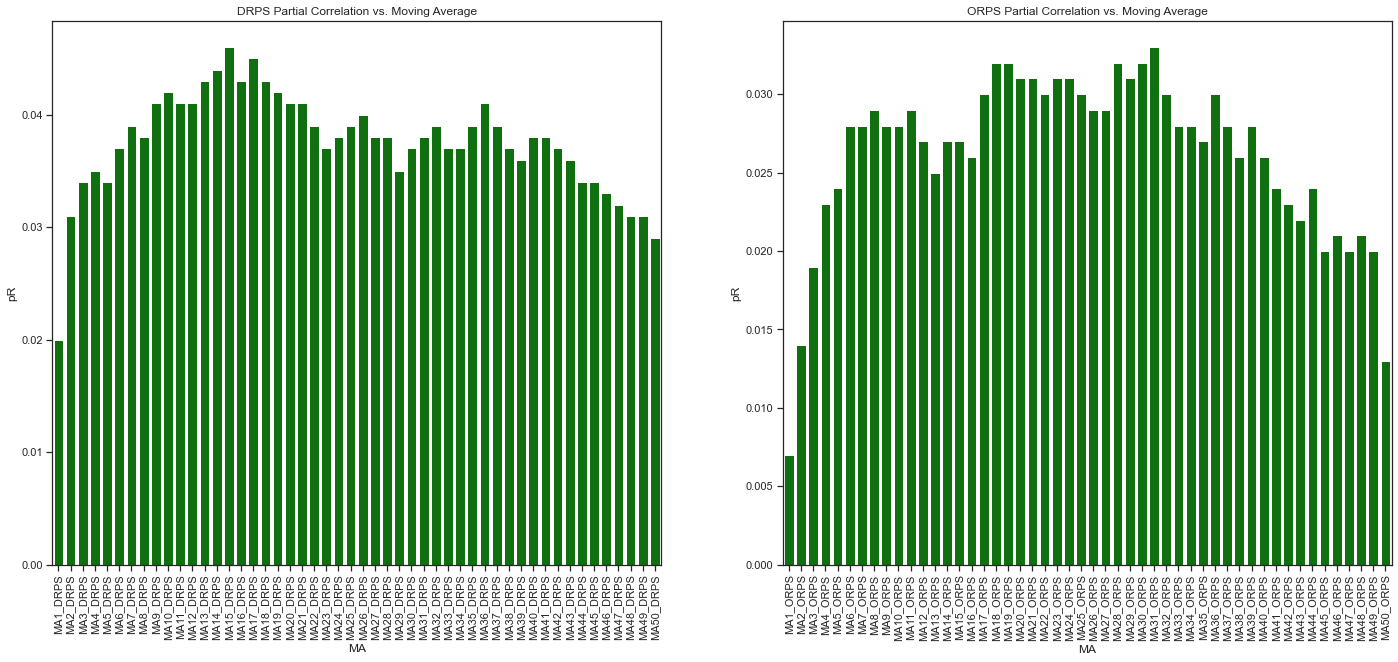

In [15]:
dreb_x_ticks = []
dreb_p_corrs = []

oreb_x_ticks = []
oreb_p_corrs = []
for i in range(1, 51):
    x = 'MA{}_DRPS'.format(str(i))

    boxscores = feature_creation.rolling_weighted_mean(
        df=boxscores, group_col_names=['SEASON', 'TEAM', 'PLAYERID'], col_name='DRPS', new_col_name=x,
        weight_col_name='SECONDSPLAYED', n_rolling=i, min_periods=math.ceil(i/2)
    )
    
    p_corr = pg.partial_corr(data=boxscores, x=x, y='CLEAN_DRPS', covar=['AVG_DRPS'])
    
    dreb_p_corrs.append(p_corr['r'][0])
    dreb_x_ticks.append(x)

    x = 'MA{}_ORPS'.format(str(i))

    boxscores = feature_creation.rolling_weighted_mean(
        df=boxscores, group_col_names=['SEASON', 'TEAM', 'PLAYERID'], col_name='ORPS', new_col_name=x,
        weight_col_name='SECONDSPLAYED', n_rolling=i, min_periods=math.ceil(i/2)
    )
    
    p_corr = pg.partial_corr(data=boxscores, x=x, y='CLEAN_ORPS', covar=['AVG_ORPS'])
    
    oreb_p_corrs.append(p_corr['r'][0])
    oreb_x_ticks.append(x)

fig, ax = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(24, 10))

dreb_corr_df = pd.DataFrame({'pR': dreb_p_corrs, 'MA': dreb_x_ticks})

sns.barplot(x='MA', y='pR', data=dreb_corr_df, color='green', ax=ax[0])
ax[0].set_xticklabels(ax[0].get_xticklabels(),rotation=90)
ax[0].title.set_text('DRPS Partial Correlation vs. Moving Average')

oreb_corr_df = pd.DataFrame({'pR': oreb_p_corrs, 'MA': oreb_x_ticks})

sns.barplot(x='MA', y='pR', data=oreb_corr_df, color='green', ax=ax[1])
ax[1].set_xticklabels(ax[1].get_xticklabels(),rotation=90)
ax[1].title.set_text('ORPS Partial Correlation vs. Moving Average')

plt.show()
plt.close()

I will use MA2_$DRPS$ and MA15_$DRPS$, and MA6_$ORPS$ and MA18_$ORPS$. $DREB$ performances seem to be more highly correlated with each other than $OREB$ performances.

In [16]:
regressors.append('MA2_DRPS')
regressors.append('MA15_DRPS')


regressors.append('MA6_ORPS')
regressors.append('MA18_ORPS')

Now I will determine if the dependant variable, $Y$, depends on various categorical variables in our data set.

First I will visualize the difference of the distributions and means of $Y$ when a player is playing at Home or Away.

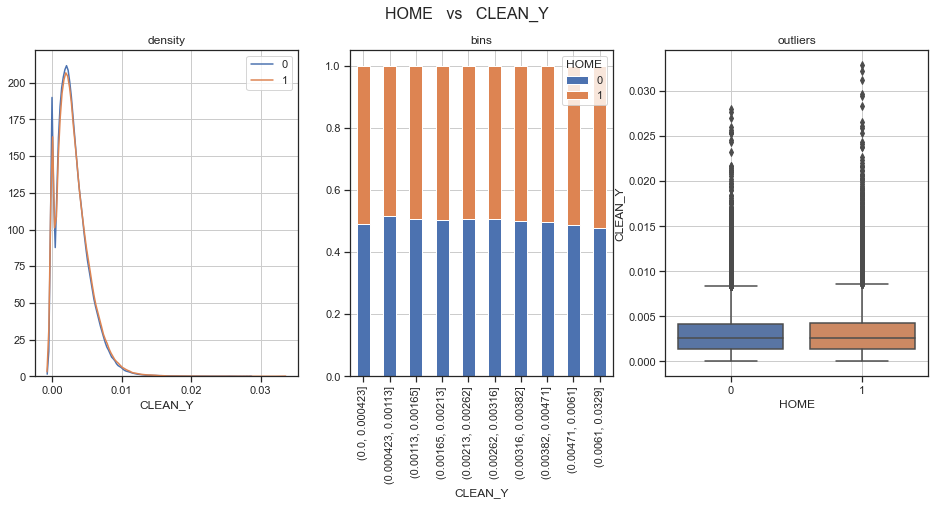

In [17]:
boxscores['HOME'] = 0
boxscores.loc[boxscores['TEAM'] == boxscores['HTM'], 'HOME'] = 1
helpers.visualize_categorical_x_vs_y(boxscores, 'HOME', clean_y)

There does not seem to be a relationship between the location a player plays at and his $RPS$.

Next I will determine if a player's $RPS$ depends on his status as a Starter.

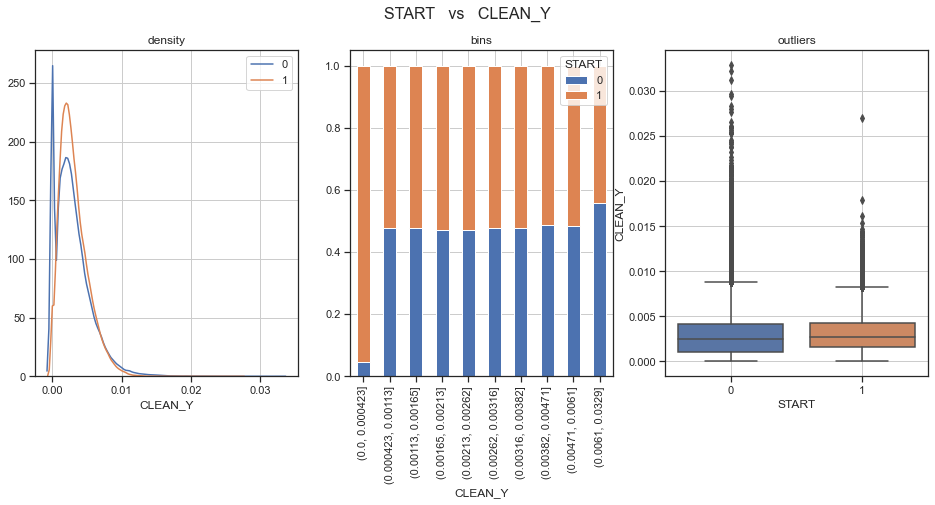

In [18]:
helpers.visualize_categorical_x_vs_y(boxscores, 'START', clean_y)

At a glance, it seems like there may be a slight relationship between starting status and $RPS$.

To confirm this hypothesis, I will investigate the percentage of (season, player) groups in the dataset exhibit a statistically significant difference between their mean $RPS$ when they start and are benched. To test significance, I will use a one-way ANOVA test.

In [19]:
num_valid_player_seasons = 0
significant_player_seasons = []
a = 0.01
for player_season, temp in boxscores.groupby(['SEASON', 'PLAYERID']):
    anova = pg.anova(dv=y, between='START', data=temp, detailed=False)
    p = anova['p-unc'].iloc[0]
    if p != '-':
        num_valid_player_seasons += 1
        if float(p) < a:
            significant_player_seasons.append(player_season)

print('Number of significant (season, player) combinations:', len(significant_player_seasons))
print('Percentage of significant (season, player) combinations:', len(significant_player_seasons)/num_valid_player_seasons)

Number of significant (season, player) combinations: 33
Percentage of significant (season, player) combinations: 0.018591549295774647


The percentage of (season, player) combinations that exibit a significant difference is 1.86%, almost twice our alpha of 1%. This is enough to add a categorical variable that identifies if a player is starting, 'START', to the list of regressors. I will also add the season average $RPS$ of a player in the role he is playing to our list of regressors. I will call this variable: $AVG\_Y\_R$.

In [20]:
regressors.append('START')
categorical_regressors.append('START')

boxscores = feature_creation.expanding_weighted_mean(
    df=boxscores, group_col_names=['SEASON', 'TEAM', 'PLAYERID', 'START'], col_name=y, weight_col_name='SECONDSPLAYED',
    new_col_name='AVG_Y_R'
)
regressors.append('AVG_Y_R')

Next, I will determine if the number of days a player rests is indicative of his $RPS$.

In [21]:
boxscores = feature_creation.lag(
    df=boxscores, group_col_names=['SEASON', 'PLAYERID'], col_name='DATE', new_col_name='LAST_DATE'
)
boxscores['LAST_DATE'] = boxscores['LAST_DATE'].apply(
    lambda x: datetime.strptime(x, '%Y-%m-%d') if isinstance(x, str) else ''
)
boxscores['DATE'] = boxscores['DATE'].apply(
    lambda x: datetime.strptime(x, '%Y-%m-%d') if isinstance(x, str) else ''
)

boxscores['REST'] = boxscores[['DATE', 'LAST_DATE']].apply(
    lambda x: max(min((x[0] - x[1]).days, 5), 1) if not (isinstance(x[0], str) or isinstance(x[1], str)) else np.nan,
    axis=1
)

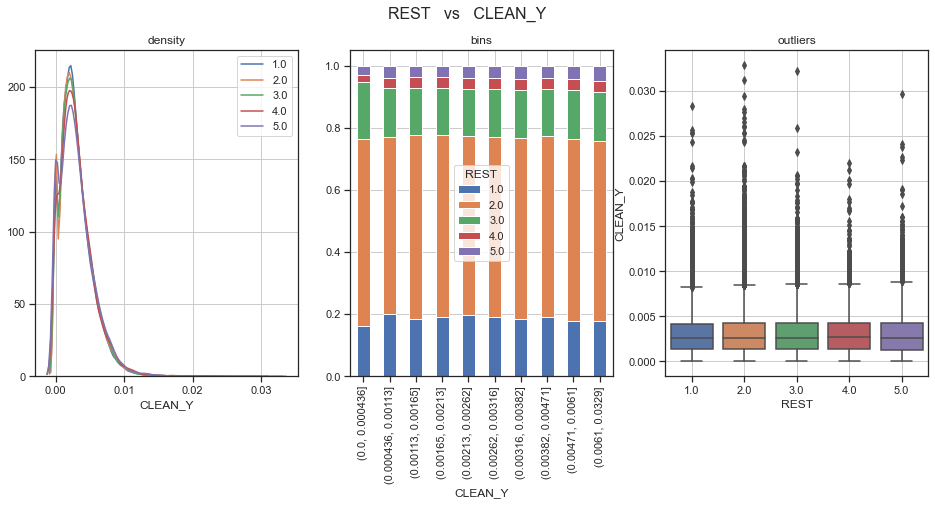

In [22]:
helpers.visualize_categorical_x_vs_y(boxscores, 'REST', clean_y)

No significant relationship.

### Position
Next, I will determine if a player's position is indicative of his $RPS$

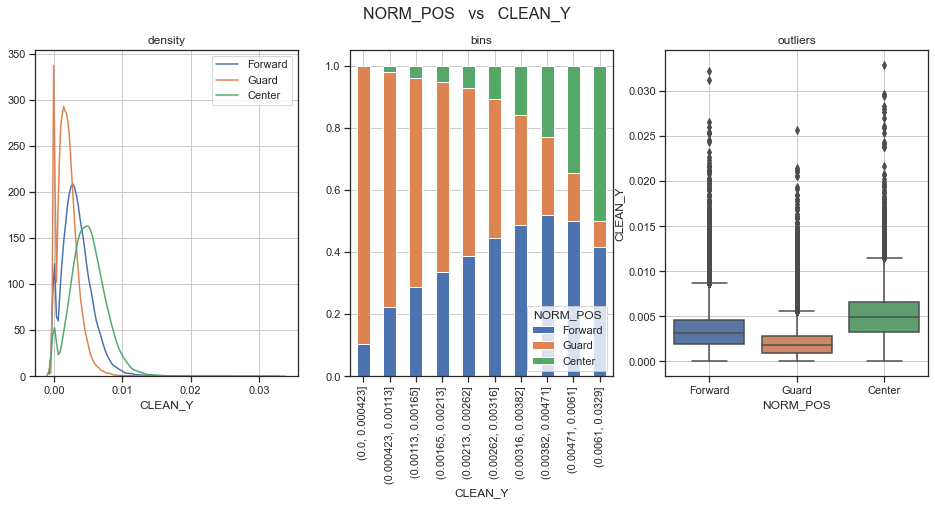

In [23]:
boxscores['NORM_POS'] = boxscores['POSITION'].apply(lambda x: x if '-' not in x else x.split('-')[0])

helpers.visualize_categorical_x_vs_y(boxscores, 'NORM_POS', clean_y)

In [24]:
boxscores['GUARD'] = 0
boxscores.loc[boxscores['NORM_POS'] == 'Guard', 'GUARD'] = 1

boxscores['FORWARD'] = 0
boxscores.loc[boxscores['NORM_POS'] == 'Forward', 'FORWARD'] = 1

boxscores['CENTER'] = 0
boxscores.loc[boxscores['NORM_POS'] == 'Center', 'CENTER'] = 1

regressors.append('GUARD')
regressors.append('FORWARD')
regressors.append('CENTER')

categorical_regressors.append('GUARD')
categorical_regressors.append('FORWARD')
categorical_regressors.append('CENTER')

### Defense
Next, I will create features based on the defense of the opposing team.

First, I will calculate the rebounding defense of each team on a game-to-game basis. I will define three metrics to measure rebounding defense:

$$TEAM\_DRPS\_DIFF\_ALLOWED =  TEAM\_DRPS\_ALLOWED - TEAM\_DRPS\_AVG$$
$$TEAM\_ORPS\_DIFF\_ALLOWED =  TEAM\_ORPS\_ALLOWED - TEAM\_ORPS\_AVG$$

where $TEAM\_DRPS\_ALLOWED$ is the DRPS allowed to the opposing team and $TEAM\_DRPS\_AVG$ is the DRPS of that team throughout the season coming into the game.

In [25]:
boxscores = feature_creation.expanding_mean(
    df=boxscores, group_col_names=['SEASON', 'TEAM', 'PLAYERID'], col_name='DREB', new_col_name='AVG_DREB'
)
boxscores = feature_creation.expanding_mean(
    df=boxscores, group_col_names=['SEASON', 'TEAM', 'PLAYERID'], col_name='OREB', new_col_name='AVG_OREB'
)
boxscores = feature_creation.expanding_mean(
    df=boxscores, group_col_names=['SEASON', 'TEAM', 'PLAYERID'], col_name='SECONDSPLAYED', new_col_name='AVG_SP'
)

temp = boxscores.dropna(subset=['DREB', 'OREB', 'SECONDSPLAYED', 'AVG_DREB', 'AVG_OREB', 'AVG_SP'])
grouped_defensive_boxscores = temp.groupby(['SEASON', 'DATE', 'OPP_TEAM']).apply(
    lambda x: pd.Series({
        'TEAM_DRPS_ALLOWED': x['DREB'].sum()/x['SECONDSPLAYED'].sum(),
        'TEAM_DRPS_AVG': x['AVG_DREB'].sum()/x['AVG_SP'].sum(),
        'TEAM_ORPS_ALLOWED': x['OREB'].sum()/x['SECONDSPLAYED'].sum(),
        'TEAM_ORPS_AVG': x['AVG_OREB'].sum()/x['AVG_SP'].sum()
    })
).reset_index()

grouped_defensive_boxscores['TEAM_DRPS_DIFF_ALLOWED'] = grouped_defensive_boxscores['TEAM_DRPS_ALLOWED'] - grouped_defensive_boxscores['TEAM_DRPS_AVG']
grouped_defensive_boxscores['TEAM_ORPS_DIFF_ALLOWED'] = grouped_defensive_boxscores['TEAM_ORPS_ALLOWED'] - grouped_defensive_boxscores['TEAM_ORPS_AVG']

Next, I will visualize the rebounding defense of each team for each season in the dataset.

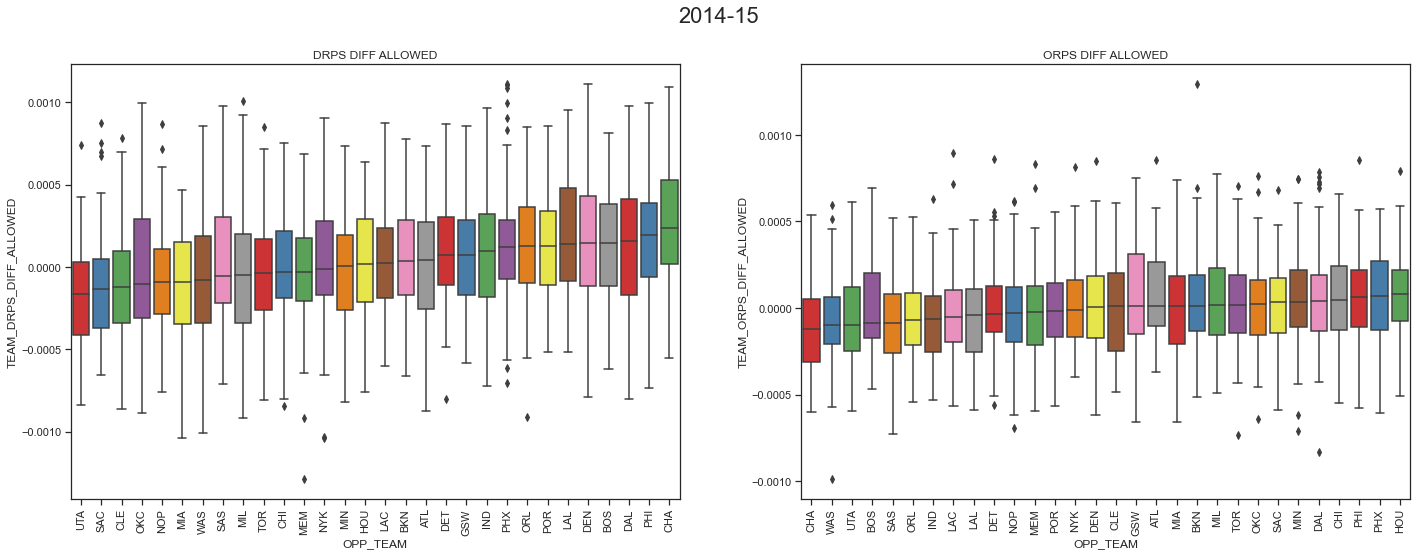

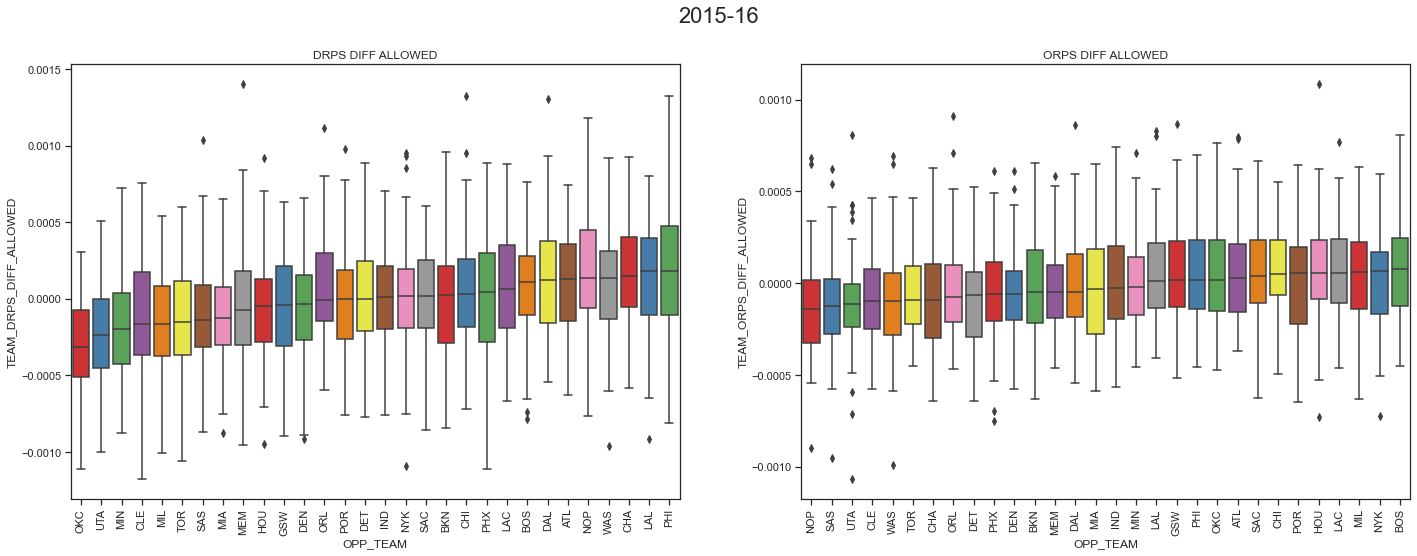

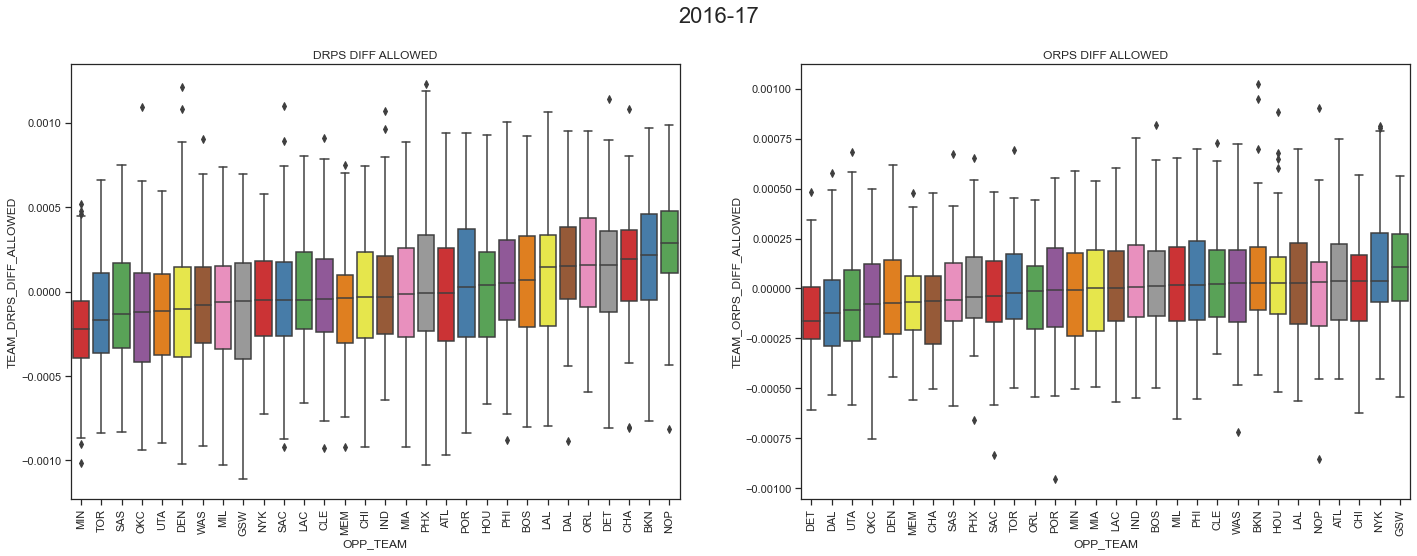

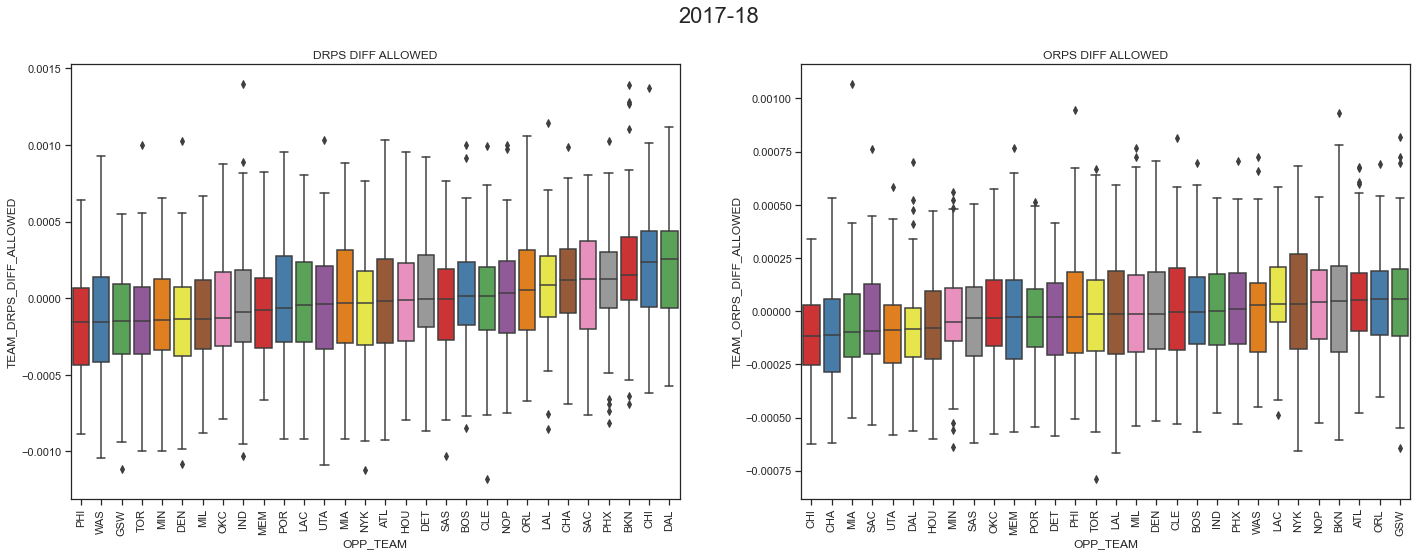

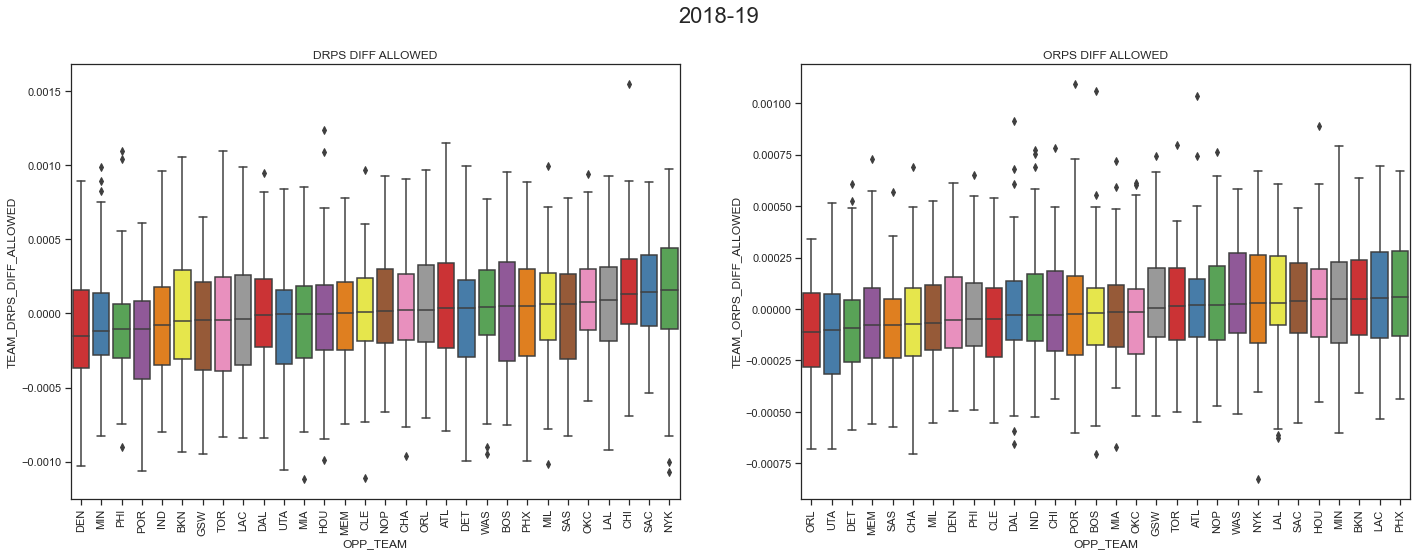

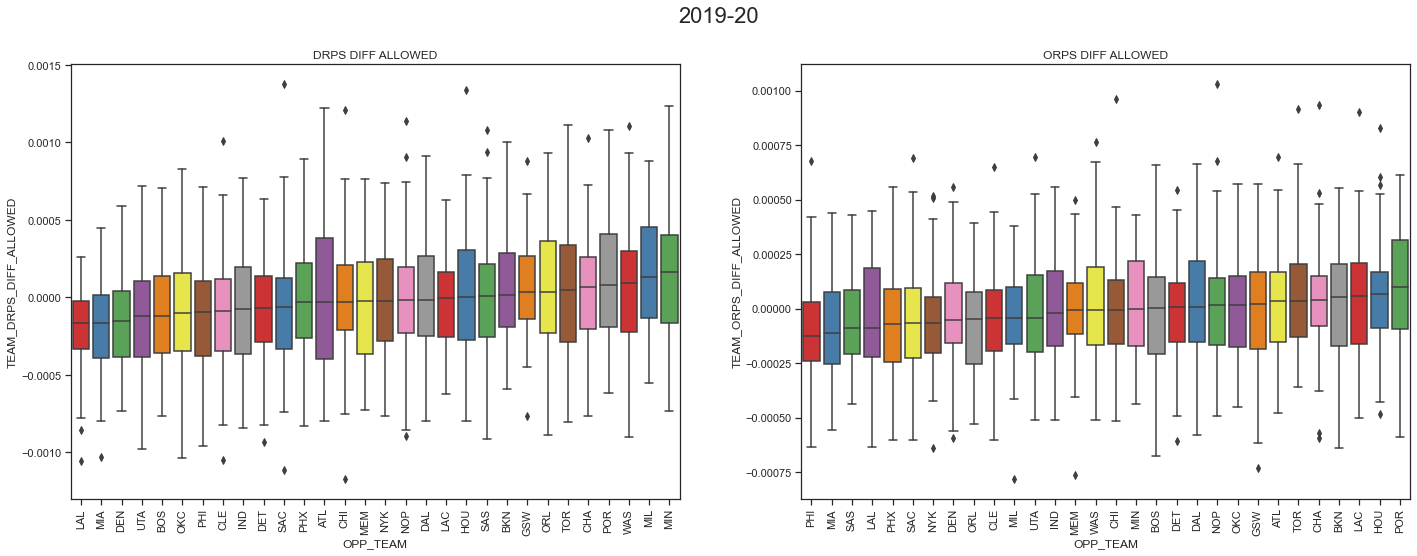

In [26]:
for season, temp in grouped_defensive_boxscores.groupby(['SEASON']):
    fig, ax = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(24, 8))
    fig.suptitle(season,fontsize=22)
    
    dreb_def = [
        (opp_team, temp2['TEAM_DRPS_DIFF_ALLOWED'].median()) for opp_team, temp2 in temp.groupby('OPP_TEAM')
    ]
    dreb_def.sort(key = lambda x: x[1])
    opp_teams = [i[0] for i in dreb_def]
    
    sns.boxplot(x="OPP_TEAM", y="TEAM_DRPS_DIFF_ALLOWED", data=temp, palette="Set1", order=opp_teams, ax=ax[0])
    ax[0].set_xticklabels(ax[0].get_xticklabels(),rotation=90)
    ax[0].title.set_text('DRPS DIFF ALLOWED')

    oreb_def = [
        (opp_team, temp2['TEAM_ORPS_DIFF_ALLOWED'].median()) for opp_team, temp2 in temp.groupby('OPP_TEAM')
    ]
    oreb_def.sort(key = lambda x: x[1])
    opp_teams = [i[0] for i in oreb_def]
    
    sns.boxplot(x="OPP_TEAM", y="TEAM_ORPS_DIFF_ALLOWED", data=temp, palette="Set1", order=opp_teams, ax=ax[1])
    ax[1].set_xticklabels(ax[1].get_xticklabels(),rotation=90)
    ax[1].title.set_text('ORPS DIFF ALLOWED')
    
    plt.show()
    plt.close()

Now, I will calculate the average reboudning defense of the opposing team across all previous games in a season, $AVG\_TEAM\_DRPS\_DIFF\_ALLOWED$ and $AVG\_TEAM\_ORPS\_DIFF\_ALLOWED$.

In [27]:
grouped_defensive_boxscores = feature_creation.expanding_mean(
    df=grouped_defensive_boxscores, group_col_names=['SEASON', 'OPP_TEAM'], col_name='TEAM_DRPS_DIFF_ALLOWED', new_col_name='AVG_TEAM_DRPS_DIFF_ALLOWED',
    order_idx_name='DATE', min_periods=5
)
grouped_defensive_boxscores = feature_creation.expanding_mean(
    df=grouped_defensive_boxscores, group_col_names=['SEASON', 'OPP_TEAM'], col_name='TEAM_ORPS_DIFF_ALLOWED', new_col_name='AVG_TEAM_ORPS_DIFF_ALLOWED',
    order_idx_name='DATE', min_periods=5
)

boxscores = boxscores.merge(grouped_defensive_boxscores, on=['SEASON', 'DATE', 'OPP_TEAM'], how='left')

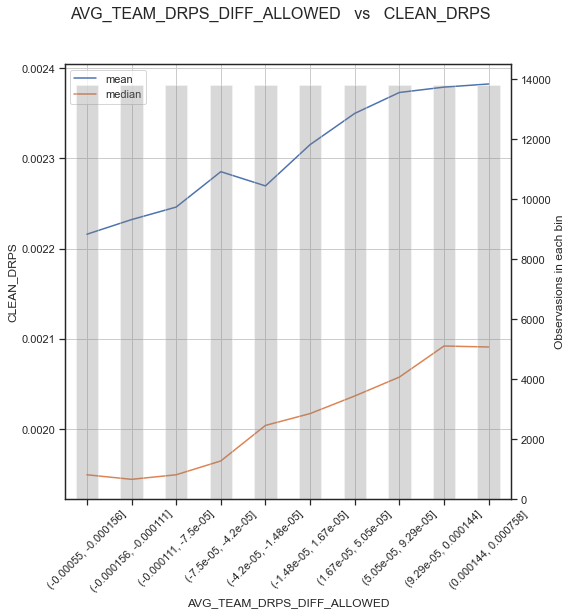

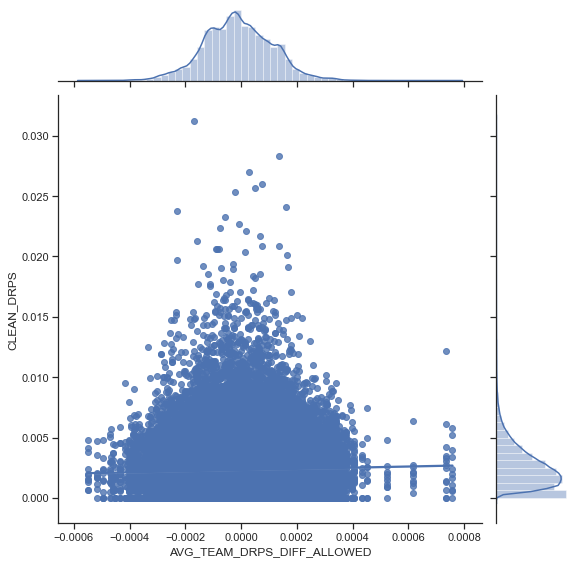

In [28]:
helpers.visualize_numeric_x_vs_y(boxscores, 'AVG_TEAM_DRPS_DIFF_ALLOWED', 'CLEAN_DRPS', figsize=(8, 8))

In [29]:
regressors.append('AVG_TEAM_DRPS_DIFF_ALLOWED')

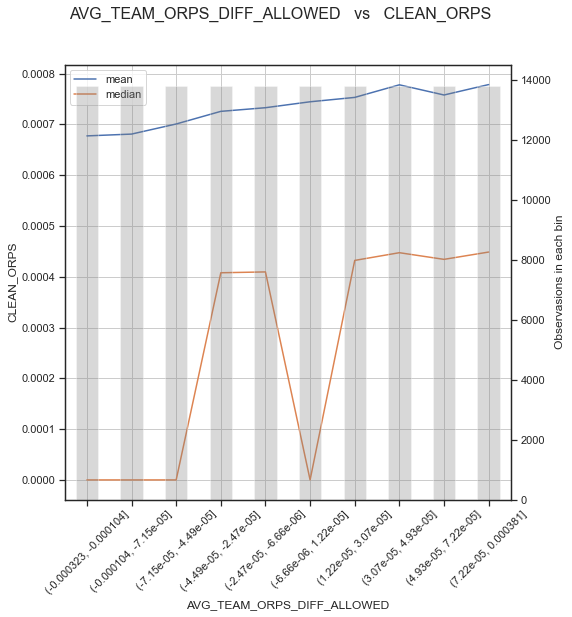

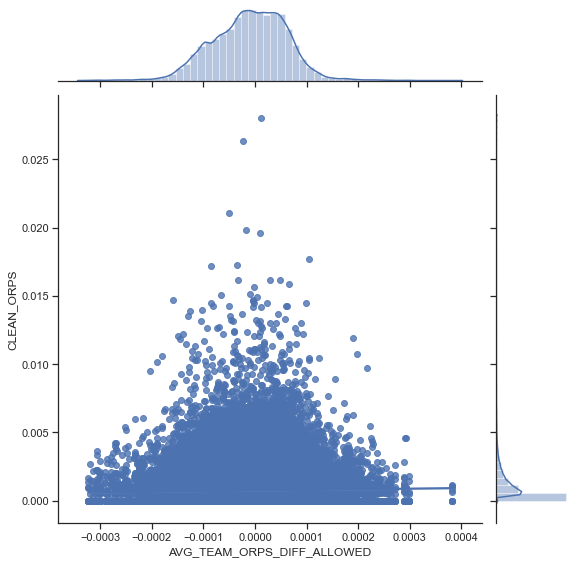

In [30]:
helpers.visualize_numeric_x_vs_y(boxscores, 'AVG_TEAM_ORPS_DIFF_ALLOWED', 'CLEAN_ORPS', figsize=(8, 8))

In [31]:
regressors.append('AVG_TEAM_ORPS_DIFF_ALLOWED')

The metrics above track the opposing team's rebounding defense on all players. However, an opposing team's rebounding defense may differ among starts and bench players, as each set will have a mostly different group of opposing players.

I will use the variables $TEAM\_DRPS\_DIFF\_ALLOWED\_R$ and $TEAM\_ORPS\_DIFF\_ALLOWED\_R$ to quantify a team's defense on opposing players by role (start/bench).

In [32]:
temp = boxscores.dropna(subset=['DREB', 'OREB', 'SECONDSPLAYED', 'AVG_DREB', 'AVG_OREB', 'AVG_SP'])
grouped_defensive_boxscores = temp.groupby(['SEASON', 'DATE', 'START', 'OPP_TEAM']).apply(
    lambda x: pd.Series({
        'TEAM_DRPS_ALLOWED_R': x['DREB'].sum()/x['SECONDSPLAYED'].sum(),
        'TEAM_DRPS_AVG_R': x['AVG_DREB'].sum()/x['AVG_SP'].sum(),
        'TEAM_ORPS_ALLOWED_R': x['OREB'].sum()/x['SECONDSPLAYED'].sum(),
        'TEAM_ORPS_AVG_R': x['AVG_OREB'].sum()/x['AVG_SP'].sum()
    })
).reset_index()

grouped_defensive_boxscores['TEAM_DRPS_DIFF_ALLOWED_R'] = grouped_defensive_boxscores['TEAM_DRPS_ALLOWED_R'] - grouped_defensive_boxscores['TEAM_DRPS_AVG_R']
grouped_defensive_boxscores['TEAM_ORPS_DIFF_ALLOWED_R'] = grouped_defensive_boxscores['TEAM_ORPS_ALLOWED_R'] - grouped_defensive_boxscores['TEAM_ORPS_AVG_R']

grouped_defensive_boxscores = feature_creation.expanding_mean(
    df=grouped_defensive_boxscores, group_col_names=['SEASON', 'START', 'OPP_TEAM'], col_name='TEAM_DRPS_DIFF_ALLOWED_R',
    new_col_name='AVG_TEAM_DRPS_DIFF_ALLOWED_R', order_idx_name='DATE', min_periods=5
)
grouped_defensive_boxscores = feature_creation.expanding_mean(
    df=grouped_defensive_boxscores, group_col_names=['SEASON', 'START', 'OPP_TEAM'], col_name='TEAM_ORPS_DIFF_ALLOWED_R',
    new_col_name='AVG_TEAM_ORPS_DIFF_ALLOWED_R', order_idx_name='DATE', min_periods=5
)

boxscores = boxscores.merge(grouped_defensive_boxscores, on=['SEASON', 'DATE', 'START', 'OPP_TEAM'], how='left')

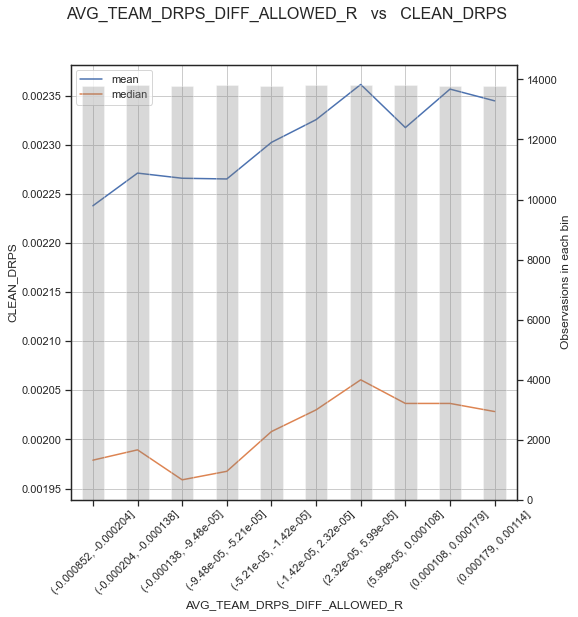

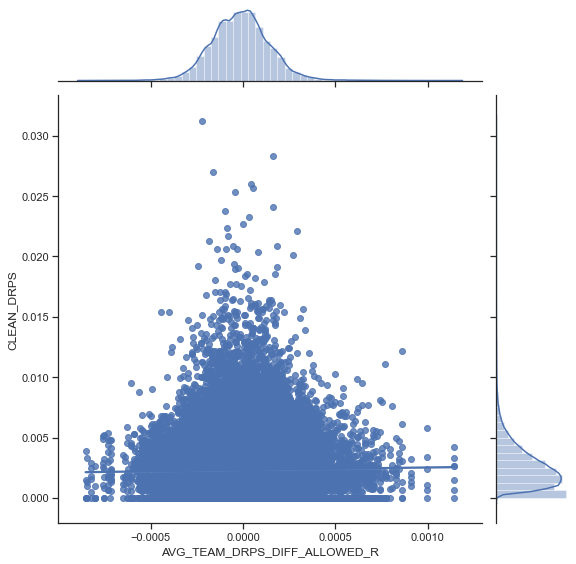

In [33]:
helpers.visualize_numeric_x_vs_y(boxscores, 'AVG_TEAM_DRPS_DIFF_ALLOWED_R', 'CLEAN_DRPS', figsize=(8, 8))

In [34]:
regressors.append('AVG_TEAM_DRPS_DIFF_ALLOWED_R')

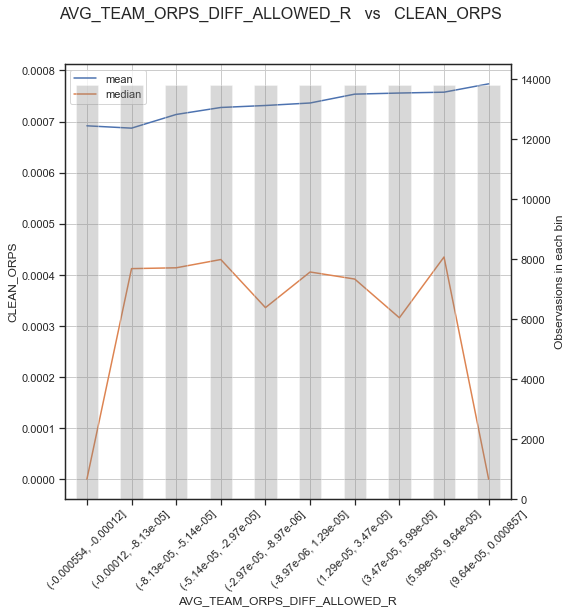

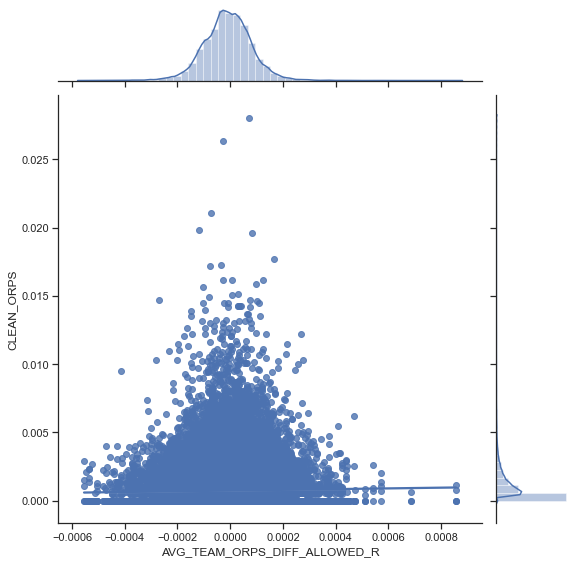

In [35]:
helpers.visualize_numeric_x_vs_y(boxscores, 'AVG_TEAM_ORPS_DIFF_ALLOWED_R', 'CLEAN_ORPS', figsize=(8, 8))

In [36]:
regressors.append('AVG_TEAM_ORPS_DIFF_ALLOWED_R')

Opposing teams may also allow more/less rebounds to different positions.

I will use the variables $TEAM\_DRPS\_DIFF\_ALLOWED\_P$ and $TEAM\_ORPS\_DIFF\_ALLOWED\_P$ to quantify a team's rebounding defense on opposing players by role (guard/forward/center).

In [37]:
temp = boxscores.dropna(subset=['DREB', 'OREB', 'SECONDSPLAYED', 'AVG_DREB', 'AVG_OREB', 'AVG_SP'])
grouped_defensive_boxscores = temp.groupby(['SEASON', 'DATE', 'NORM_POS', 'OPP_TEAM']).apply(
    lambda x: pd.Series({
        'TEAM_DRPS_ALLOWED_P': x['DREB'].sum()/x['SECONDSPLAYED'].sum(),
        'TEAM_DRPS_AVG_P': x['AVG_DREB'].sum()/x['AVG_SP'].sum(),
        'TEAM_ORPS_ALLOWED_P': x['OREB'].sum()/x['SECONDSPLAYED'].sum(),
        'TEAM_ORPS_AVG_P': x['AVG_OREB'].sum()/x['AVG_SP'].sum()
    })
).reset_index()

grouped_defensive_boxscores['TEAM_DRPS_DIFF_ALLOWED_P'] = grouped_defensive_boxscores['TEAM_DRPS_ALLOWED_P'] - grouped_defensive_boxscores['TEAM_DRPS_AVG_P']
grouped_defensive_boxscores['TEAM_ORPS_DIFF_ALLOWED_P'] = grouped_defensive_boxscores['TEAM_ORPS_ALLOWED_P'] - grouped_defensive_boxscores['TEAM_ORPS_AVG_P']

grouped_defensive_boxscores = feature_creation.expanding_mean(
    df=grouped_defensive_boxscores, group_col_names=['SEASON', 'NORM_POS', 'OPP_TEAM'], col_name='TEAM_DRPS_DIFF_ALLOWED_P',
    new_col_name='AVG_TEAM_DRPS_DIFF_ALLOWED_P', order_idx_name='DATE', min_periods=5
)
grouped_defensive_boxscores = feature_creation.expanding_mean(
    df=grouped_defensive_boxscores, group_col_names=['SEASON', 'NORM_POS', 'OPP_TEAM'], col_name='TEAM_ORPS_DIFF_ALLOWED_P',
    new_col_name='AVG_TEAM_ORPS_DIFF_ALLOWED_P', order_idx_name='DATE', min_periods=5
)

boxscores = boxscores.merge(grouped_defensive_boxscores, on=['SEASON', 'DATE', 'NORM_POS', 'OPP_TEAM'], how='left')

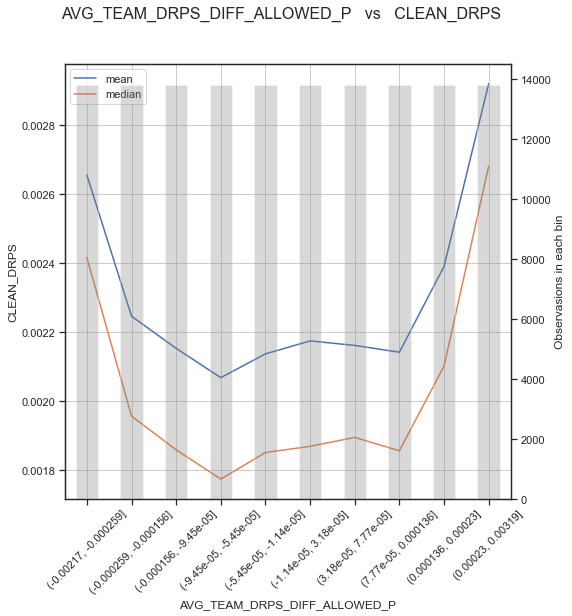

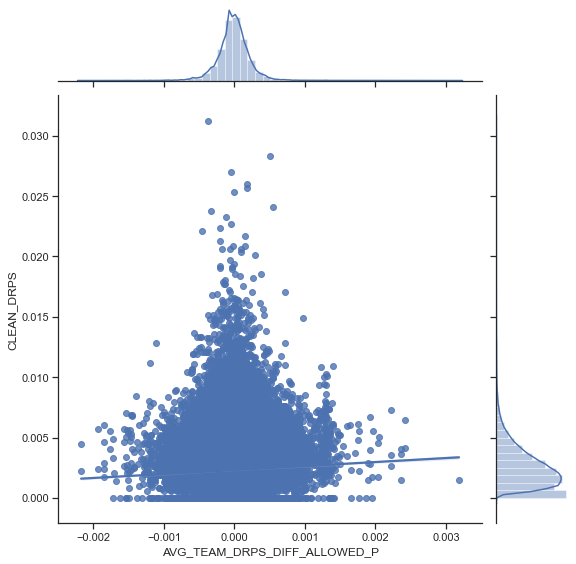

In [38]:
helpers.visualize_numeric_x_vs_y(boxscores, 'AVG_TEAM_DRPS_DIFF_ALLOWED_P', 'CLEAN_DRPS', figsize=(8, 8))

In [39]:
regressors.append('AVG_TEAM_DRPS_DIFF_ALLOWED_P')

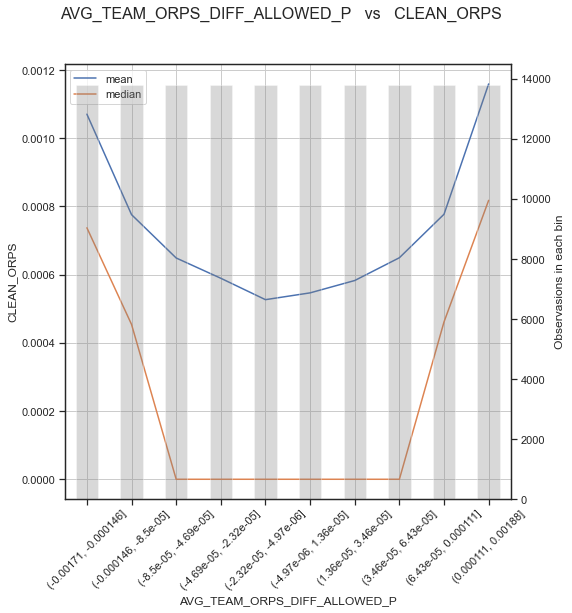

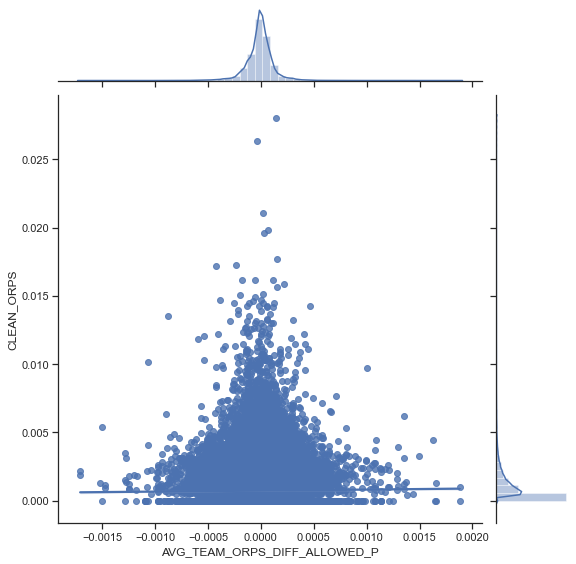

In [40]:
helpers.visualize_numeric_x_vs_y(boxscores, 'AVG_TEAM_ORPS_DIFF_ALLOWED_P', 'CLEAN_ORPS', figsize=(8, 8))

In [41]:
regressors.append('AVG_TEAM_ORPS_DIFF_ALLOWED_P')

I will also include the vegas implied game point total as a feature.

In [42]:
odds = query_data.query_odds_data()
odds['TOTAL'] = odds['TOTAL'].replace(['PK', '-'], np.nan)
full_game_odds = odds.loc[odds['PERIOD'] == 'Full Game']

In [43]:
full_game_odds['DATE'] = full_game_odds['DATE'].apply(
    lambda x: datetime.strptime(x, '%Y-%m-%d') if isinstance(x, str) else ''
)

boxscores = boxscores.merge(full_game_odds, on=['DATE', 'TEAM'], how='left')

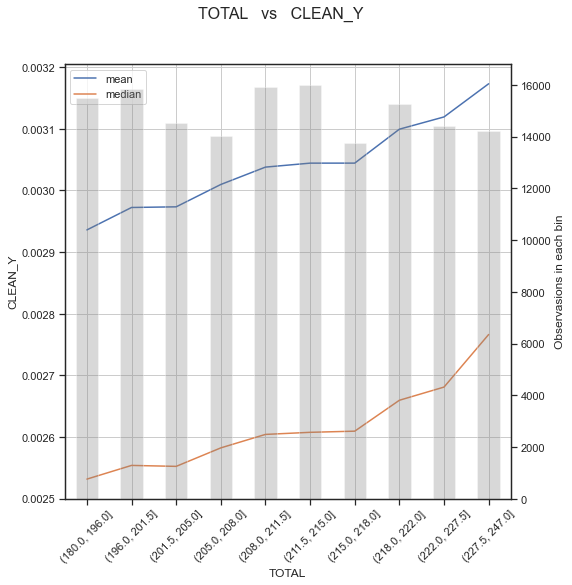

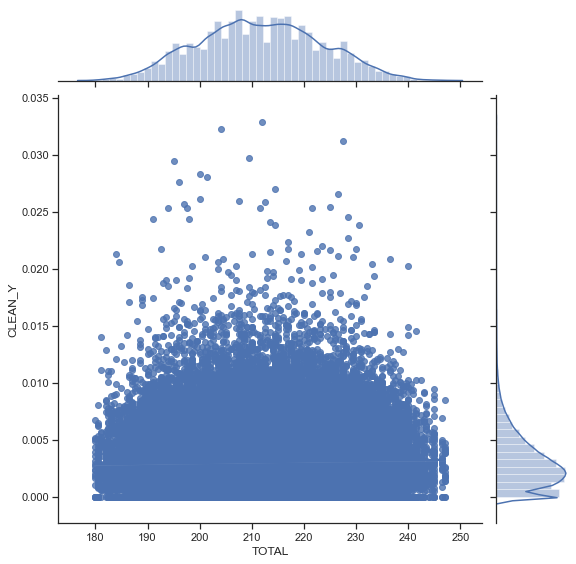

In [44]:
helpers.visualize_numeric_x_vs_y(boxscores, 'TOTAL', clean_y, figsize=(8, 8))

In [45]:
regressors.append('TOTAL')

### Injuries
Finally, I will create features that quantify how injured the lineup is from a production standpoint.

The first variable I will create to capture how injured the lineup is (from a rebouding standpoint) will be called $TEAM\_ACTIVE\_AVG\_DRPS\_DIFF$. This will capture the difference between the DRPS of the players of a team active in a game, and the average DRPS of that team. For example, if the sum of the average seconds played of the active players on a team was 14400, and the sum of the average DREB of the active players on the team was 40, the $TEAM\_ACTIVE\_AVG\_DRPS$ would be $40/14400 = 0.00278$. If the next game, Andre Drummond was out (who is on the team and averaged 2000 seconds played and 10 DREB) the $TEAM\_ACTIVE\_AVG\_DRPS$ would be $(40-10)/(14400-2000) = 0.00242$. In this case $TEAM\_ACTIVE\_AVG\_FGAPS\_DIFF$ would be $0.00242-0.00278 = -0.00036$. This lower number would hopefully be more indicative of a higher $RPS$ for the rest of the team.

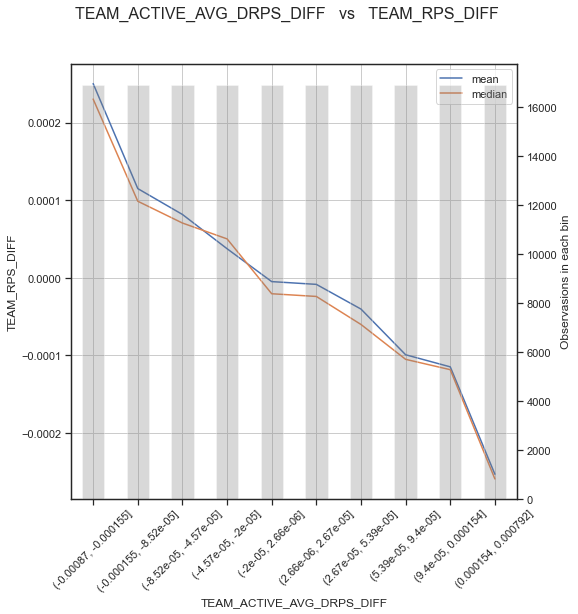

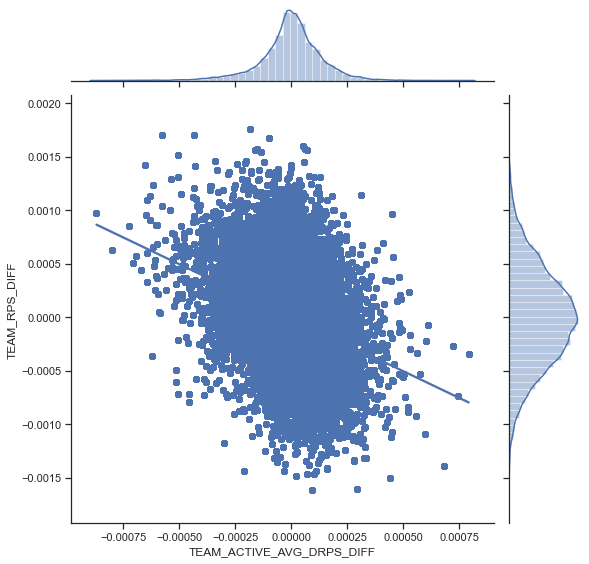

In [46]:
boxscores = feature_creation.expanding_mean(
    df=boxscores, group_col_names=['SEASON', 'TEAM', 'PLAYERID'], col_name='REB', new_col_name='AVG_REB'
)

temp = boxscores.dropna(subset=['DREB', 'AVG_DREB', 'SECONDSPLAYED', 'AVG_SP'])
temp = temp.groupby(['SEASON', 'GAMEID', 'TEAM']).apply(
    lambda x: pd.Series({
        'TEAM_ACTIVE_AVG_DRPS': x['AVG_DREB'].sum()/x['AVG_SP'].sum(),
        'TEAM_DRPS': x['DREB'].sum()/x['SECONDSPLAYED'].sum(),
        'TEAM_ACTIVE_AVG_RPS': x['AVG_REB'].sum()/x['AVG_SP'].sum(),
        'TEAM_RPS': x['REB'].sum()/x['SECONDSPLAYED'].sum()
    })
)
temp = feature_creation.expanding_mean(
    df=temp, group_col_names=['SEASON', 'TEAM'], col_name='TEAM_DRPS', new_col_name='AVG_TEAM_DRPS'
)
temp['TEAM_ACTIVE_AVG_DRPS_DIFF'] = temp['TEAM_ACTIVE_AVG_DRPS'] - temp['AVG_TEAM_DRPS']
temp['TEAM_RPS_DIFF'] = temp['TEAM_RPS'] - temp['TEAM_ACTIVE_AVG_RPS']

boxscores = boxscores.merge(temp, on=['GAMEID', 'TEAM'], how='left')
helpers.visualize_numeric_x_vs_y(boxscores, 'TEAM_ACTIVE_AVG_DRPS_DIFF', 'TEAM_RPS_DIFF', figsize=(8, 8))

It seems as though a lower $TEAM\_ACTIVE\_AVG\_DRPS\_DIFF$ is indicative of a higher $TEAM\_RPS$ than the active players average. I will add this to my list of regressors.

In [47]:
regressors.append('TEAM_ACTIVE_AVG_DRPS_DIFF')

Not all players absorb lost usage equally. To account for this, I will create a feature that tracks the $AVG\_RPS$ of players when the starting lineup was the same. I will also create a feature that tracks the $AVG\_RPS$ of players when the active star players on the team were the same (I will define 'star player' in this context as a player who averages at least 7 Defenive Rebounds Per Game).

In [48]:
boxscores['START_LINEUP'] = np.nan
boxscores['STARS'] = np.nan
boxscores = boxscores.set_index(['GAMEID', 'TEAM'])
for (game_id, team), temp in boxscores.groupby(['GAMEID', 'TEAM']):
    start_lineup = list(temp.loc[temp['START'] == 1, 'PLAYERID'].values)
    start_lineup.sort()
    start_lineup = '_'.join(start_lineup)
    boxscores.loc[(game_id, team), 'START_LINEUP'] = start_lineup
    
    stars = list(temp.loc[temp['AVG_DREB'] >= 7, 'PLAYERID'].values)
    stars.sort()
    stars = '_'.join(stars)
    boxscores.loc[(game_id, team), 'STARS'] = stars
boxscores = boxscores.reset_index()

boxscores = feature_creation.expanding_weighted_mean(
    df=boxscores, group_col_names=['SEASON', 'START_LINEUP', 'PLAYERID'], col_name=y, weight_col_name='SECONDSPLAYED',
    new_col_name='AVG_Y_STARTERS'
)

boxscores = feature_creation.expanding_weighted_mean(
    df=boxscores, group_col_names=['SEASON', 'STARS', 'PLAYERID'], col_name=y, weight_col_name='SECONDSPLAYED',
    new_col_name='AVG_Y_STARS'
)

To determine if these features provide new information, I will calcuate the partial correlation between each of them and the dependant variable, using $AVG\_Y$ as the covariate.

In [49]:
boxscores = feature_creation.expanding_weighted_mean(
    df=boxscores, group_col_names=['SEASON', 'TEAM', 'PLAYERID'], col_name='Y', weight_col_name='SECONDSPLAYED', new_col_name='AVG_Y'
)

print('Partial correlation between AVG_Y_STARTERS and Y with covariate AVG_Y:')
pc = pg.partial_corr(data=boxscores, x='AVG_Y_STARTERS', y=clean_y, covar=['AVG_Y'])
display(pc)

print('Partial correlation between AVG_Y_STARS and Y with covariate AVG_Y:')
pc = pg.partial_corr(data=boxscores, x='AVG_Y_STARS', y=clean_y, covar=['AVG_Y'])
display(pc)

Partial correlation between AVG_Y_STARTERS and Y with covariate AVG_Y:


,n,r,CI95%,r2,adj_r2,p-val,BF10,power
pearson,110230,0.013,"[0.01, 0.02]",0.0,0.0,0.000019,35.59,0.99


Partial correlation between AVG_Y_STARS and Y with covariate AVG_Y:


,n,r,CI95%,r2,adj_r2,p-val,BF10,power
pearson,141377,0.022,"[0.02, 0.03]",0.0,0.0,1.319347e-16,2.402e+12,1.0


These features both show a significant partial correlation with the dependent variable. I will add them to the list of regressors.

In [50]:
regressors.append('AVG_Y_STARTERS')
regressors.append('AVG_Y_STARS')

### Weights
Lastly, I will add a column to weight each $Y$ value. I do not care about each occurance of the dependant variable equally; the $RPS$ of a player who collects 1 rebound in 120 seconds should not be weighted the same as the $RPS$ of a plyer who collects 15 rebounds in 1800 seconds. 

The weight I will use will be a product of functions of the amount of seconds played in a game and the sum of seconds played by a player throughout that season:

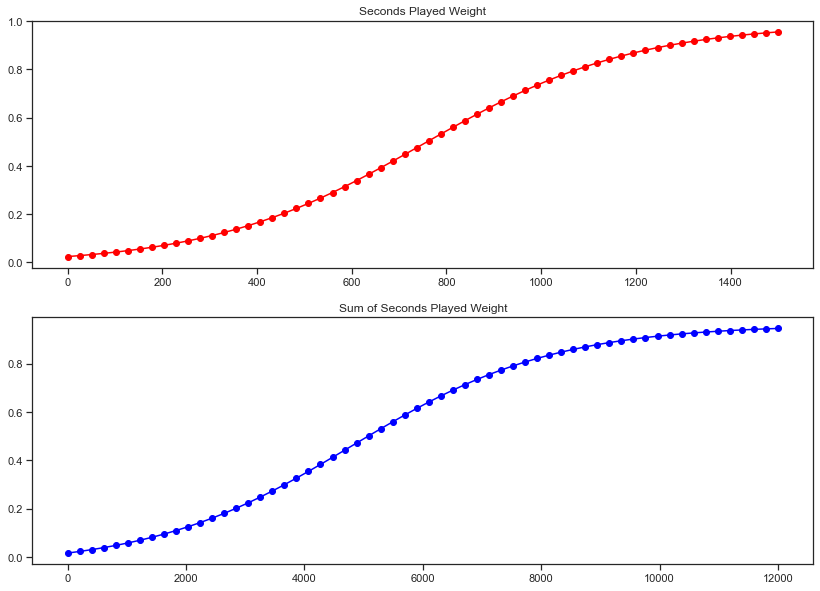

In [51]:
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=False, sharey=False, figsize=(14, 10))

sp_weight_func = lambda x: 1/(1 + np.exp((-0.80*x + 600)/180)) - 0.01
sp_in_array = np.linspace(0, 60*25, 60)
sp_out_array = sp_weight_func(sp_in_array) 

tsp_weight_func = lambda x: 1/(1 + np.exp((-0.175*x + 840)/300)) - 0.04
tsp_in_array = np.linspace(0, 60*20*10, 60)
tsp_out_array = tsp_weight_func(tsp_in_array)

ax[0].title.set_text("Seconds Played Weight") 
ax[0].plot(sp_in_array, sp_out_array, color ='red', marker="o")

ax[1].title.set_text("Sum of Seconds Played Weight") 
ax[1].plot(tsp_in_array, tsp_out_array, color ='blue', marker="o") 
plt.show() 

In [52]:
boxscores = feature_creation.expanding_sum(
    df=boxscores, group_col_names=['SEASON', 'PLAYERID'], col_name='SECONDSPLAYED', new_col_name='SUM_SP'
)

w = 'WEIGHT'
boxscores[w] = boxscores['SECONDSPLAYED'].apply(sp_weight_func) * boxscores['SUM_SP'].apply(tsp_weight_func)

Some features we created to track historical performances mean less if the player has played less games/ minutes. To tell the non-linear models how much the player has played, I will create 2 regressors: number of games played ($COUNT\_GP$) and average seconds played ($AVG\_SP$)

In [53]:
boxscores['GP'] = 1
boxscores = feature_creation.expanding_sum(df=boxscores, group_col_names=['SEASON', 'PLAYERID'], col_name='GP', new_col_name='COUNT_GP')
regressors.append('COUNT_GP')


regressors.append('AVG_SP')

# Preprocessing
Now that I have created all the features I found to be indicative of our dependant variable, I will prepare the data to be suitable for a predictive model.

The first thing I will do is handle missing data.

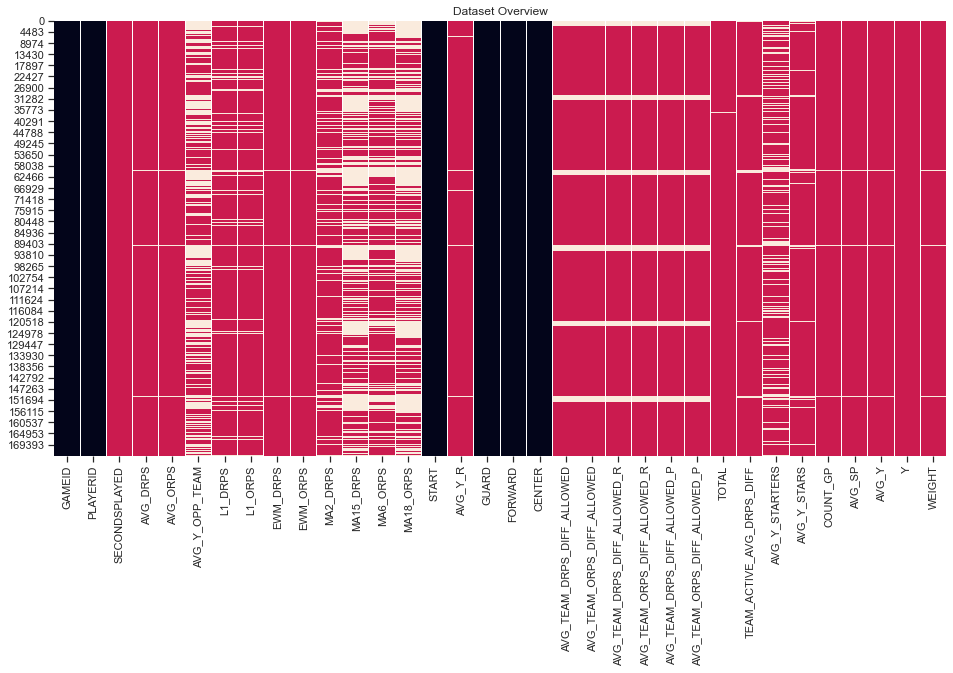

 Categerocial   Numeric   NaN 

Percentage of rows containing at least one missing value: 70.868


In [54]:
fill_cols = ['AVG_Y']
feature_matrix = boxscores[['GAMEID', 'PLAYERID', 'SECONDSPLAYED'] + regressors + fill_cols + [y] + [w]]

#drop games in which players played a minute or less
feature_matrix = feature_matrix.loc[feature_matrix['SECONDSPLAYED'] > 60]

helpers.visualize_dataframe(feature_matrix)

In [55]:
feature_matrix['AVG_Y_R'] = feature_matrix['AVG_Y_R'].fillna(feature_matrix['AVG_Y'])
feature_matrix['AVG_Y_OPP_TEAM'] = feature_matrix['AVG_Y_OPP_TEAM'].fillna(feature_matrix['AVG_Y'])
feature_matrix['L1_DRPS'] = feature_matrix['L1_DRPS'].fillna(feature_matrix['AVG_DRPS'])
feature_matrix['L1_ORPS'] = feature_matrix['L1_ORPS'].fillna(feature_matrix['AVG_ORPS'])
feature_matrix['EWM_DRPS'] = feature_matrix['EWM_DRPS'].fillna(feature_matrix['AVG_DRPS'])
feature_matrix['EWM_ORPS'] = feature_matrix['EWM_ORPS'].fillna(feature_matrix['AVG_ORPS'])
feature_matrix['MA2_DRPS'] = feature_matrix['MA2_DRPS'].fillna(feature_matrix['AVG_DRPS'])
feature_matrix['MA15_DRPS'] = feature_matrix['MA15_DRPS'].fillna(feature_matrix['MA2_DRPS'])
feature_matrix['MA6_ORPS'] = feature_matrix['MA6_ORPS'].fillna(feature_matrix['AVG_ORPS'])
feature_matrix['MA18_ORPS'] = feature_matrix['MA18_ORPS'].fillna(feature_matrix['MA6_ORPS'])

feature_matrix['AVG_TEAM_DRPS_DIFF_ALLOWED'] = feature_matrix['AVG_TEAM_DRPS_DIFF_ALLOWED'].fillna(0)
feature_matrix['AVG_TEAM_ORPS_DIFF_ALLOWED'] = feature_matrix['AVG_TEAM_ORPS_DIFF_ALLOWED'].fillna(0)
feature_matrix['AVG_TEAM_DRPS_DIFF_ALLOWED_R'] = feature_matrix['AVG_TEAM_DRPS_DIFF_ALLOWED_R'].fillna(0)
feature_matrix['AVG_TEAM_ORPS_DIFF_ALLOWED_R'] = feature_matrix['AVG_TEAM_ORPS_DIFF_ALLOWED_R'].fillna(0)
feature_matrix['AVG_TEAM_DRPS_DIFF_ALLOWED_P'] = feature_matrix['AVG_TEAM_DRPS_DIFF_ALLOWED_P'].fillna(0)
feature_matrix['AVG_TEAM_ORPS_DIFF_ALLOWED_P'] = feature_matrix['AVG_TEAM_ORPS_DIFF_ALLOWED_P'].fillna(0)

feature_matrix['TEAM_ACTIVE_AVG_DRPS_DIFF'] = feature_matrix['TEAM_ACTIVE_AVG_DRPS_DIFF'].fillna(0)
feature_matrix['AVG_Y_STARS'] = feature_matrix['AVG_Y_STARS'].fillna(feature_matrix['AVG_Y'])
feature_matrix['AVG_Y_STARTERS'] = feature_matrix['AVG_Y_STARTERS'].fillna(feature_matrix['AVG_Y_STARS'])

feature_matrix['COUNT_GP'] = feature_matrix['COUNT_GP'].fillna(0)

feature_matrix['TOTAL'] = feature_matrix['TOTAL'].fillna(200)

# we can predict Y for a player as long as AVG_Y is not nan
feature_matrix = feature_matrix.dropna(subset=['AVG_Y'])

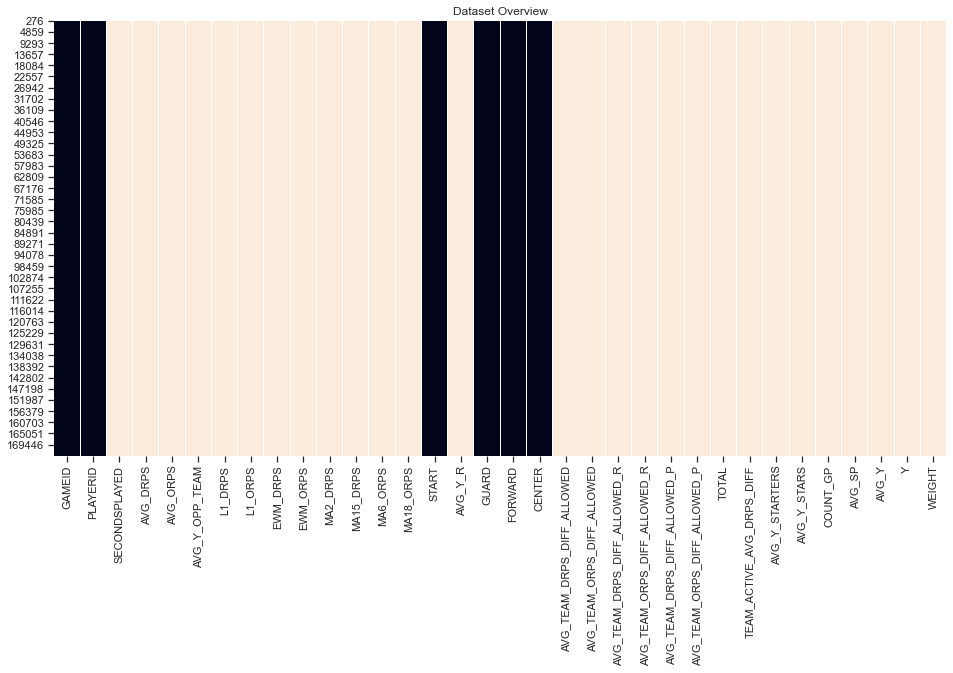

 Categerocial   Numeric   NaN 

Percentage of rows containing at least one missing value: 0.0


In [56]:
helpers.visualize_dataframe(feature_matrix)

# Model/Feature Selection
Finally, it's time to build the model. I will first iterate through various model types. Within each model iteration, I will isolate the important features. I will also try predicting the log transform of the dependant variable, and scaling the numeric columns, and pick whatever (Model, Feature Subset, \[Log Transform, No Transform\], \[Scale, No Scale\]) combination yeilds the lowest average MSE after 5-fold cross validation.

In [57]:
linear_models = [
    linear_model.LinearRegression()
#     linear_model.Ridge(),
#     linear_model.ElasticNet()
]

neighbor_models = [
#     neighbors.KNeighborsRegressor()
]

boosted_models = [
    xgb.XGBRegressor(objective='reg:squarederror', eval_metric='mae', learning_rate=0.1, n_estimators=500, tree_method='hist'),
    CatBoostRegressor(eval_metric='MAE', learning_rate=0.1, n_estimators=500, silent=True)
    
]

neural_networks = [
    neural_network.MLPRegressor(max_iter=10000, early_stopping=True, random_state=42)
]

models = linear_models + neighbor_models + boosted_models + neural_networks

transformers = [
    {
        'Function': lambda x: x,
        'Inverse Function': lambda x: x,
        'Name': 'None'
    },
    {
        'Function': lambda x: np.log(x + 1),
        'Inverse Function': lambda x: np.exp(x) - 1,
        'Name': 'Log'
    }
]

numeric_regressors = list(set(regressors) - set(categorical_regressors))
numeric_columns = numeric_regressors + [y]

min_score = float('inf')
best_model = None
for model in models:
    for transformer in transformers:
        for scale in [False, True]:
            
            # transform numeric columns
            temp_feature_matrix = feature_matrix.copy()
            temp_feature_matrix[numeric_columns] = temp_feature_matrix[numeric_columns].apply(
                transformer['Function'], axis=1
            )
            
            # scale numeric features
            if scale:
                x_scaler = preprocessing.RobustScaler(quantile_range=(25.0, 75.0))
                temp_feature_matrix[numeric_regressors] = x_scaler.fit_transform(temp_feature_matrix[numeric_regressors])
                
                y_scaler = preprocessing.RobustScaler(quantile_range=(25.0, 75.0))
                temp_feature_matrix[[y]] = y_scaler.fit_transform(temp_feature_matrix[[y]])

            # feature selection
            X = temp_feature_matrix[regressors]
            Y = temp_feature_matrix[y]
            W = temp_feature_matrix[w]

            if model in (neighbor_models + neural_networks):
                selected_features = regressors.copy()
            else:
                model.fit(X, Y, sample_weight=W)
                
                # importance
                importance_selector = SelectFromModel(model, threshold='0.75*median')
                importance_selector = importance_selector.fit(X, Y, sample_weight=W)
                importance_support = importance_selector.get_support()
                
                # rank
                rank_selector = RFE(model)
                rank_selector = rank_selector.fit(X, Y)
                rank_support = rank_selector.ranking_
                median_rank = np.median(rank_support)
                
                selected_features = []
                for feature, importance_flag, rank in zip(list(X.columns), importance_support, rank_support):
                    # select the feature if it's important, or has a low rank
                    if importance_flag or (rank <= median_rank):
                        selected_features.append(feature)

            X = temp_feature_matrix[selected_features].values
            Y = temp_feature_matrix[y].values
            W = temp_feature_matrix[w].values
            
            # cross validation
            scores = []
            cv = model_selection.KFold(n_splits=5, shuffle=True)
            for train, test in cv.split(X, Y, W):
                if model in (neural_networks + neighbor_models):
                    prediction = model.fit(X[train], Y[train]).predict(X[test])
                else:
                    prediction = model.fit(X[train], Y[train], sample_weight=W[train]).predict(X[test])
                true = Y[test]

                if scale:
                    prediction = y_scaler.inverse_transform(prediction.reshape(-1,1)).reshape(-1)
                    true = y_scaler.inverse_transform(true.reshape(-1,1)).reshape(-1)

                prediction = transformer['Inverse Function'](prediction)
                true = transformer['Inverse Function'](true)
                
                scores.append(metrics.mean_absolute_error(prediction, true, sample_weight=W[test]))

            mean_score = np.mean(scores)
            print('\nModel:', model)
            print('Transformer:', transformer['Name'])
            print('Scale:', scale)
            print('Selected Features:', selected_features)
            print('Mean MAE:', mean_score)
            if mean_score < min_score:
                min_score = mean_score
                best_model = (model, transformer['Name'], scale, selected_features)
print()
print(best_model, min_score)


Model: LinearRegression()
Transformer: None
Scale: False
Selected Features: ['AVG_DRPS', 'AVG_ORPS', 'MA2_DRPS', 'MA6_ORPS', 'MA18_ORPS', 'AVG_Y_R', 'AVG_TEAM_DRPS_DIFF_ALLOWED', 'AVG_TEAM_ORPS_DIFF_ALLOWED', 'AVG_TEAM_DRPS_DIFF_ALLOWED_R', 'AVG_TEAM_ORPS_DIFF_ALLOWED_R', 'AVG_TEAM_DRPS_DIFF_ALLOWED_P', 'AVG_TEAM_ORPS_DIFF_ALLOWED_P', 'TEAM_ACTIVE_AVG_DRPS_DIFF', 'AVG_Y_STARS']
Mean MAE: 0.0011711741465470229

Model: LinearRegression()
Transformer: None
Scale: True
Selected Features: ['AVG_DRPS', 'AVG_ORPS', 'L1_DRPS', 'EWM_DRPS', 'MA2_DRPS', 'MA6_ORPS', 'MA18_ORPS', 'START', 'AVG_Y_R', 'GUARD', 'FORWARD', 'CENTER', 'AVG_TEAM_DRPS_DIFF_ALLOWED', 'AVG_TEAM_DRPS_DIFF_ALLOWED_P', 'AVG_TEAM_ORPS_DIFF_ALLOWED_P', 'TOTAL', 'TEAM_ACTIVE_AVG_DRPS_DIFF', 'AVG_Y_STARS']
Mean MAE: 0.001168139602397421

Model: LinearRegression()
Transformer: Log
Scale: False
Selected Features: ['AVG_DRPS', 'AVG_ORPS', 'MA2_DRPS', 'MA6_ORPS', 'MA18_ORPS', 'AVG_Y_R', 'AVG_TEAM_DRPS_DIFF_ALLOWED', 'AVG_TEAM_ORPS_DIF


Model: MLPRegressor(early_stopping=True, max_iter=10000, random_state=42)
Transformer: None
Scale: False
Selected Features: ['AVG_DRPS', 'AVG_ORPS', 'AVG_Y_OPP_TEAM', 'L1_DRPS', 'L1_ORPS', 'EWM_DRPS', 'EWM_ORPS', 'MA2_DRPS', 'MA15_DRPS', 'MA6_ORPS', 'MA18_ORPS', 'START', 'AVG_Y_R', 'GUARD', 'FORWARD', 'CENTER', 'AVG_TEAM_DRPS_DIFF_ALLOWED', 'AVG_TEAM_ORPS_DIFF_ALLOWED', 'AVG_TEAM_DRPS_DIFF_ALLOWED_R', 'AVG_TEAM_ORPS_DIFF_ALLOWED_R', 'AVG_TEAM_DRPS_DIFF_ALLOWED_P', 'AVG_TEAM_ORPS_DIFF_ALLOWED_P', 'TOTAL', 'TEAM_ACTIVE_AVG_DRPS_DIFF', 'AVG_Y_STARTERS', 'AVG_Y_STARS', 'COUNT_GP', 'AVG_SP']
Mean MAE: 0.008714487926712488

Model: MLPRegressor(early_stopping=True, max_iter=10000, random_state=42)
Transformer: None
Scale: True
Selected Features: ['AVG_DRPS', 'AVG_ORPS', 'AVG_Y_OPP_TEAM', 'L1_DRPS', 'L1_ORPS', 'EWM_DRPS', 'EWM_ORPS', 'MA2_DRPS', 'MA15_DRPS', 'MA6_ORPS', 'MA18_ORPS', 'START', 'AVG_Y_R', 'GUARD', 'FORWARD', 'CENTER', 'AVG_TEAM_DRPS_DIFF_ALLOWED', 'AVG_TEAM_ORPS_DIFF_ALLOWED', '

The best model is a Catboost model with no log transformations or scaling.

# Parameter Tuning
Now, I will use Grid Search Cross Validation to find the CatBoostRegressor paramters that yeild the lowest average MSE on the test set.

In [58]:
selected_features = ['AVG_DRPS', 'AVG_ORPS', 'AVG_Y_OPP_TEAM', 'L1_DRPS', 'EWM_DRPS', 'EWM_ORPS',
                     'MA2_DRPS', 'MA15_DRPS', 'MA6_ORPS', 'MA18_ORPS', 'AVG_Y_R', 'GUARD',
                     'AVG_TEAM_DRPS_DIFF_ALLOWED', 'AVG_TEAM_DRPS_DIFF_ALLOWED_R', 'AVG_TEAM_DRPS_DIFF_ALLOWED_P',
                     'AVG_TEAM_ORPS_DIFF_ALLOWED_P', 'TOTAL', 'TEAM_ACTIVE_AVG_DRPS_DIFF', 'AVG_Y_STARTERS',
                     'AVG_Y_STARS', 'COUNT_GP', 'AVG_SP']
# selected_features = best_model[3]
X = feature_matrix[selected_features]
Y = feature_matrix[y]
W = feature_matrix[w]
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(X, Y, W, test_size=0.25, random_state=1)

In [59]:
model = CatBoostRegressor()

model_params = {
    'depth': [4, 6, 8, 10],
    'learning_rate' : [0.01, 0.02, 0.05, 0.1],
    'num_boost_round': [5000],
    'eval_metric': ['MAE']
}

grid = GridSearchCV(estimator=model, param_grid=model_params, scoring='neg_mean_absolute_error', cv=2, n_jobs=-1)

fit_params = {
    "early_stopping_rounds": 25,
    "eval_set": (X_test, y_test),
    'sample_weight': w_train
}

grid.fit(X_train, y_train, **fit_params)    

print("\n========================================================")
print(" Results from Grid Search " )
print("========================================================")    

print("\n The best estimator across ALL searched params:\n", grid.best_estimator_)

print("\n The best score across ALL searched params:\n", grid.best_score_)

print("\n The best parameters across ALL searched params:\n", grid.best_params_)

print("\n ========================================================")

0:	learn: 0.0015951	test: 0.0017593	best: 0.0017593 (0)	total: 22.9ms	remaining: 1m 54s
1:	learn: 0.0015881	test: 0.0017529	best: 0.0017529 (1)	total: 40.7ms	remaining: 1m 41s
2:	learn: 0.0015812	test: 0.0017466	best: 0.0017466 (2)	total: 58.6ms	remaining: 1m 37s
3:	learn: 0.0015744	test: 0.0017404	best: 0.0017404 (3)	total: 74.5ms	remaining: 1m 33s
4:	learn: 0.0015678	test: 0.0017344	best: 0.0017344 (4)	total: 90.9ms	remaining: 1m 30s
5:	learn: 0.0015612	test: 0.0017283	best: 0.0017283 (5)	total: 107ms	remaining: 1m 29s
6:	learn: 0.0015547	test: 0.0017224	best: 0.0017224 (6)	total: 124ms	remaining: 1m 28s
7:	learn: 0.0015483	test: 0.0017166	best: 0.0017166 (7)	total: 141ms	remaining: 1m 28s
8:	learn: 0.0015421	test: 0.0017109	best: 0.0017109 (8)	total: 159ms	remaining: 1m 27s
9:	learn: 0.0015360	test: 0.0017053	best: 0.0017053 (9)	total: 175ms	remaining: 1m 27s
10:	learn: 0.0015299	test: 0.0016998	best: 0.0016998 (10)	total: 192ms	remaining: 1m 27s
11:	learn: 0.0015238	test: 0.0016943

95:	learn: 0.0012550	test: 0.0014525	best: 0.0014525 (95)	total: 1.73s	remaining: 1m 28s
96:	learn: 0.0012535	test: 0.0014513	best: 0.0014513 (96)	total: 1.76s	remaining: 1m 28s
97:	learn: 0.0012521	test: 0.0014500	best: 0.0014500 (97)	total: 1.78s	remaining: 1m 29s
98:	learn: 0.0012507	test: 0.0014488	best: 0.0014488 (98)	total: 1.8s	remaining: 1m 29s
99:	learn: 0.0012493	test: 0.0014476	best: 0.0014476 (99)	total: 1.82s	remaining: 1m 29s
100:	learn: 0.0012480	test: 0.0014465	best: 0.0014465 (100)	total: 1.84s	remaining: 1m 29s
101:	learn: 0.0012467	test: 0.0014453	best: 0.0014453 (101)	total: 1.86s	remaining: 1m 29s
102:	learn: 0.0012454	test: 0.0014442	best: 0.0014442 (102)	total: 1.88s	remaining: 1m 29s
103:	learn: 0.0012441	test: 0.0014431	best: 0.0014431 (103)	total: 1.89s	remaining: 1m 29s
104:	learn: 0.0012429	test: 0.0014420	best: 0.0014420 (104)	total: 1.91s	remaining: 1m 29s
105:	learn: 0.0012416	test: 0.0014409	best: 0.0014409 (105)	total: 1.93s	remaining: 1m 28s
106:	learn

188:	learn: 0.0011861	test: 0.0013946	best: 0.0013946 (188)	total: 3.63s	remaining: 1m 32s
189:	learn: 0.0011858	test: 0.0013943	best: 0.0013943 (189)	total: 3.64s	remaining: 1m 32s
190:	learn: 0.0011854	test: 0.0013941	best: 0.0013941 (190)	total: 3.66s	remaining: 1m 32s
191:	learn: 0.0011851	test: 0.0013938	best: 0.0013938 (191)	total: 3.68s	remaining: 1m 32s
192:	learn: 0.0011848	test: 0.0013936	best: 0.0013936 (192)	total: 3.69s	remaining: 1m 32s
193:	learn: 0.0011845	test: 0.0013934	best: 0.0013934 (193)	total: 3.71s	remaining: 1m 31s
194:	learn: 0.0011842	test: 0.0013931	best: 0.0013931 (194)	total: 3.73s	remaining: 1m 31s
195:	learn: 0.0011839	test: 0.0013929	best: 0.0013929 (195)	total: 3.75s	remaining: 1m 31s
196:	learn: 0.0011836	test: 0.0013927	best: 0.0013927 (196)	total: 3.77s	remaining: 1m 31s
197:	learn: 0.0011833	test: 0.0013924	best: 0.0013924 (197)	total: 3.79s	remaining: 1m 31s
198:	learn: 0.0011831	test: 0.0013922	best: 0.0013922 (198)	total: 3.8s	remaining: 1m 31s


288:	learn: 0.0011682	test: 0.0013817	best: 0.0013817 (288)	total: 5.49s	remaining: 1m 29s
289:	learn: 0.0011681	test: 0.0013816	best: 0.0013816 (289)	total: 5.51s	remaining: 1m 29s
290:	learn: 0.0011680	test: 0.0013816	best: 0.0013816 (290)	total: 5.54s	remaining: 1m 29s
291:	learn: 0.0011679	test: 0.0013815	best: 0.0013815 (291)	total: 5.57s	remaining: 1m 29s
292:	learn: 0.0011678	test: 0.0013815	best: 0.0013815 (292)	total: 5.59s	remaining: 1m 29s
293:	learn: 0.0011678	test: 0.0013814	best: 0.0013814 (293)	total: 5.61s	remaining: 1m 29s
294:	learn: 0.0011677	test: 0.0013814	best: 0.0013814 (294)	total: 5.63s	remaining: 1m 29s
295:	learn: 0.0011676	test: 0.0013813	best: 0.0013813 (295)	total: 5.65s	remaining: 1m 29s
296:	learn: 0.0011675	test: 0.0013812	best: 0.0013812 (296)	total: 5.67s	remaining: 1m 29s
297:	learn: 0.0011674	test: 0.0013812	best: 0.0013812 (297)	total: 5.68s	remaining: 1m 29s
298:	learn: 0.0011673	test: 0.0013811	best: 0.0013811 (298)	total: 5.7s	remaining: 1m 29s


381:	learn: 0.0011620	test: 0.0013782	best: 0.0013782 (381)	total: 7.2s	remaining: 1m 26s
382:	learn: 0.0011620	test: 0.0013782	best: 0.0013782 (382)	total: 7.25s	remaining: 1m 27s
383:	learn: 0.0011619	test: 0.0013781	best: 0.0013781 (383)	total: 7.27s	remaining: 1m 27s
384:	learn: 0.0011619	test: 0.0013781	best: 0.0013781 (384)	total: 7.29s	remaining: 1m 27s
385:	learn: 0.0011619	test: 0.0013781	best: 0.0013781 (385)	total: 7.3s	remaining: 1m 27s
386:	learn: 0.0011618	test: 0.0013781	best: 0.0013781 (386)	total: 7.32s	remaining: 1m 27s
387:	learn: 0.0011618	test: 0.0013780	best: 0.0013780 (387)	total: 7.33s	remaining: 1m 27s
388:	learn: 0.0011617	test: 0.0013780	best: 0.0013780 (388)	total: 7.35s	remaining: 1m 27s
389:	learn: 0.0011617	test: 0.0013780	best: 0.0013780 (389)	total: 7.37s	remaining: 1m 27s
390:	learn: 0.0011616	test: 0.0013780	best: 0.0013780 (390)	total: 7.38s	remaining: 1m 27s
391:	learn: 0.0011616	test: 0.0013780	best: 0.0013780 (391)	total: 7.4s	remaining: 1m 26s
39

476:	learn: 0.0011582	test: 0.0013766	best: 0.0013766 (476)	total: 9.08s	remaining: 1m 26s
477:	learn: 0.0011582	test: 0.0013766	best: 0.0013766 (477)	total: 9.1s	remaining: 1m 26s
478:	learn: 0.0011581	test: 0.0013766	best: 0.0013766 (478)	total: 9.11s	remaining: 1m 25s
479:	learn: 0.0011581	test: 0.0013765	best: 0.0013765 (479)	total: 9.13s	remaining: 1m 25s
480:	learn: 0.0011581	test: 0.0013765	best: 0.0013765 (480)	total: 9.14s	remaining: 1m 25s
481:	learn: 0.0011581	test: 0.0013765	best: 0.0013765 (481)	total: 9.16s	remaining: 1m 25s
482:	learn: 0.0011580	test: 0.0013765	best: 0.0013765 (482)	total: 9.18s	remaining: 1m 25s
483:	learn: 0.0011580	test: 0.0013765	best: 0.0013765 (483)	total: 9.19s	remaining: 1m 25s
484:	learn: 0.0011580	test: 0.0013765	best: 0.0013765 (484)	total: 9.21s	remaining: 1m 25s
485:	learn: 0.0011579	test: 0.0013764	best: 0.0013764 (485)	total: 9.23s	remaining: 1m 25s
486:	learn: 0.0011579	test: 0.0013764	best: 0.0013764 (486)	total: 9.24s	remaining: 1m 25s


570:	learn: 0.0011555	test: 0.0013756	best: 0.0013756 (570)	total: 10.8s	remaining: 1m 23s
571:	learn: 0.0011554	test: 0.0013756	best: 0.0013756 (571)	total: 10.8s	remaining: 1m 23s
572:	learn: 0.0011554	test: 0.0013756	best: 0.0013756 (572)	total: 10.8s	remaining: 1m 23s
573:	learn: 0.0011554	test: 0.0013756	best: 0.0013756 (573)	total: 10.8s	remaining: 1m 23s
574:	learn: 0.0011554	test: 0.0013755	best: 0.0013755 (574)	total: 10.9s	remaining: 1m 23s
575:	learn: 0.0011553	test: 0.0013755	best: 0.0013755 (575)	total: 10.9s	remaining: 1m 23s
576:	learn: 0.0011553	test: 0.0013755	best: 0.0013755 (576)	total: 10.9s	remaining: 1m 23s
577:	learn: 0.0011553	test: 0.0013755	best: 0.0013755 (577)	total: 11s	remaining: 1m 23s
578:	learn: 0.0011552	test: 0.0013755	best: 0.0013755 (578)	total: 11s	remaining: 1m 23s
579:	learn: 0.0011552	test: 0.0013755	best: 0.0013755 (579)	total: 11s	remaining: 1m 23s
580:	learn: 0.0011552	test: 0.0013755	best: 0.0013755 (580)	total: 11s	remaining: 1m 23s
581:	le

666:	learn: 0.0011530	test: 0.0013749	best: 0.0013749 (666)	total: 12.7s	remaining: 1m 22s
667:	learn: 0.0011530	test: 0.0013749	best: 0.0013749 (666)	total: 12.7s	remaining: 1m 22s
668:	learn: 0.0011530	test: 0.0013749	best: 0.0013749 (668)	total: 12.7s	remaining: 1m 22s
669:	learn: 0.0011529	test: 0.0013749	best: 0.0013749 (669)	total: 12.7s	remaining: 1m 22s
670:	learn: 0.0011529	test: 0.0013749	best: 0.0013749 (670)	total: 12.7s	remaining: 1m 22s
671:	learn: 0.0011529	test: 0.0013749	best: 0.0013749 (671)	total: 12.8s	remaining: 1m 22s
672:	learn: 0.0011529	test: 0.0013749	best: 0.0013749 (672)	total: 12.8s	remaining: 1m 22s
673:	learn: 0.0011528	test: 0.0013749	best: 0.0013749 (672)	total: 12.8s	remaining: 1m 22s
674:	learn: 0.0011528	test: 0.0013749	best: 0.0013749 (674)	total: 12.8s	remaining: 1m 22s
675:	learn: 0.0011528	test: 0.0013749	best: 0.0013749 (675)	total: 12.8s	remaining: 1m 21s
676:	learn: 0.0011527	test: 0.0013749	best: 0.0013749 (676)	total: 12.8s	remaining: 1m 21s

769:	learn: 0.0011505	test: 0.0013744	best: 0.0013744 (767)	total: 14.3s	remaining: 1m 18s
770:	learn: 0.0011505	test: 0.0013744	best: 0.0013744 (767)	total: 14.3s	remaining: 1m 18s
771:	learn: 0.0011505	test: 0.0013744	best: 0.0013744 (767)	total: 14.3s	remaining: 1m 18s
772:	learn: 0.0011504	test: 0.0013744	best: 0.0013744 (767)	total: 14.4s	remaining: 1m 18s
773:	learn: 0.0011504	test: 0.0013744	best: 0.0013744 (773)	total: 14.4s	remaining: 1m 18s
774:	learn: 0.0011504	test: 0.0013744	best: 0.0013744 (773)	total: 14.4s	remaining: 1m 18s
775:	learn: 0.0011504	test: 0.0013744	best: 0.0013744 (775)	total: 14.4s	remaining: 1m 18s
776:	learn: 0.0011503	test: 0.0013744	best: 0.0013744 (775)	total: 14.4s	remaining: 1m 18s
777:	learn: 0.0011503	test: 0.0013744	best: 0.0013744 (777)	total: 14.4s	remaining: 1m 18s
778:	learn: 0.0011503	test: 0.0013744	best: 0.0013744 (778)	total: 14.4s	remaining: 1m 18s
779:	learn: 0.0011503	test: 0.0013744	best: 0.0013744 (779)	total: 14.5s	remaining: 1m 18s

870:	learn: 0.0011483	test: 0.0013739	best: 0.0013739 (870)	total: 16.2s	remaining: 1m 16s
871:	learn: 0.0011482	test: 0.0013739	best: 0.0013739 (871)	total: 16.2s	remaining: 1m 16s
872:	learn: 0.0011482	test: 0.0013739	best: 0.0013739 (871)	total: 16.2s	remaining: 1m 16s
873:	learn: 0.0011482	test: 0.0013739	best: 0.0013739 (873)	total: 16.2s	remaining: 1m 16s
874:	learn: 0.0011482	test: 0.0013739	best: 0.0013739 (873)	total: 16.3s	remaining: 1m 16s
875:	learn: 0.0011481	test: 0.0013739	best: 0.0013739 (875)	total: 16.3s	remaining: 1m 16s
876:	learn: 0.0011481	test: 0.0013739	best: 0.0013739 (876)	total: 16.3s	remaining: 1m 16s
877:	learn: 0.0011481	test: 0.0013739	best: 0.0013739 (877)	total: 16.3s	remaining: 1m 16s
878:	learn: 0.0011481	test: 0.0013739	best: 0.0013739 (877)	total: 16.3s	remaining: 1m 16s
879:	learn: 0.0011480	test: 0.0013739	best: 0.0013739 (877)	total: 16.3s	remaining: 1m 16s
880:	learn: 0.0011480	test: 0.0013739	best: 0.0013739 (880)	total: 16.4s	remaining: 1m 16s

968:	learn: 0.0011459	test: 0.0013736	best: 0.0013736 (968)	total: 18.1s	remaining: 1m 15s
969:	learn: 0.0011459	test: 0.0013736	best: 0.0013736 (969)	total: 18.1s	remaining: 1m 15s
970:	learn: 0.0011459	test: 0.0013736	best: 0.0013736 (970)	total: 18.1s	remaining: 1m 15s
971:	learn: 0.0011459	test: 0.0013736	best: 0.0013736 (971)	total: 18.1s	remaining: 1m 15s
972:	learn: 0.0011459	test: 0.0013736	best: 0.0013736 (972)	total: 18.1s	remaining: 1m 15s
973:	learn: 0.0011458	test: 0.0013736	best: 0.0013736 (973)	total: 18.2s	remaining: 1m 15s
974:	learn: 0.0011458	test: 0.0013736	best: 0.0013736 (974)	total: 18.2s	remaining: 1m 15s
975:	learn: 0.0011458	test: 0.0013736	best: 0.0013736 (975)	total: 18.2s	remaining: 1m 15s
976:	learn: 0.0011458	test: 0.0013736	best: 0.0013736 (976)	total: 18.2s	remaining: 1m 14s
977:	learn: 0.0011457	test: 0.0013736	best: 0.0013736 (977)	total: 18.2s	remaining: 1m 14s
978:	learn: 0.0011457	test: 0.0013736	best: 0.0013736 (977)	total: 18.2s	remaining: 1m 14s

1057:	learn: 0.0011440	test: 0.0013734	best: 0.0013734 (1052)	total: 19.5s	remaining: 1m 12s
1058:	learn: 0.0011440	test: 0.0013734	best: 0.0013734 (1052)	total: 19.5s	remaining: 1m 12s
1059:	learn: 0.0011440	test: 0.0013734	best: 0.0013734 (1052)	total: 19.5s	remaining: 1m 12s
1060:	learn: 0.0011440	test: 0.0013734	best: 0.0013734 (1060)	total: 19.6s	remaining: 1m 12s
1061:	learn: 0.0011439	test: 0.0013734	best: 0.0013734 (1060)	total: 19.6s	remaining: 1m 12s
1062:	learn: 0.0011439	test: 0.0013734	best: 0.0013734 (1062)	total: 19.6s	remaining: 1m 12s
1063:	learn: 0.0011439	test: 0.0013734	best: 0.0013734 (1063)	total: 19.6s	remaining: 1m 12s
1064:	learn: 0.0011439	test: 0.0013734	best: 0.0013734 (1064)	total: 19.6s	remaining: 1m 12s
1065:	learn: 0.0011439	test: 0.0013734	best: 0.0013734 (1065)	total: 19.6s	remaining: 1m 12s
1066:	learn: 0.0011438	test: 0.0013734	best: 0.0013734 (1066)	total: 19.7s	remaining: 1m 12s
1067:	learn: 0.0011438	test: 0.0013734	best: 0.0013734 (1067)	total: 1

1149:	learn: 0.0011420	test: 0.0013732	best: 0.0013731 (1136)	total: 21s	remaining: 1m 10s
1150:	learn: 0.0011420	test: 0.0013732	best: 0.0013731 (1136)	total: 21s	remaining: 1m 10s
1151:	learn: 0.0011420	test: 0.0013732	best: 0.0013731 (1136)	total: 21s	remaining: 1m 10s
1152:	learn: 0.0011420	test: 0.0013732	best: 0.0013731 (1136)	total: 21s	remaining: 1m 10s
1153:	learn: 0.0011419	test: 0.0013732	best: 0.0013731 (1136)	total: 21s	remaining: 1m 10s
1154:	learn: 0.0011419	test: 0.0013732	best: 0.0013731 (1136)	total: 21s	remaining: 1m 10s
1155:	learn: 0.0011419	test: 0.0013732	best: 0.0013731 (1136)	total: 21.1s	remaining: 1m 9s
1156:	learn: 0.0011419	test: 0.0013732	best: 0.0013731 (1136)	total: 21.1s	remaining: 1m 9s
1157:	learn: 0.0011419	test: 0.0013732	best: 0.0013731 (1136)	total: 21.1s	remaining: 1m 9s
1158:	learn: 0.0011418	test: 0.0013731	best: 0.0013731 (1136)	total: 21.1s	remaining: 1m 9s
1159:	learn: 0.0011418	test: 0.0013731	best: 0.0013731 (1136)	total: 21.1s	remaining: 

# Evaluation
Lastly, I will evaluate the final model.

In [60]:
best_params = grid.best_params_
model = CatBoostRegressor(**best_params)

weighted_eval_set = Pool(
    data=X_test,
    label=y_test,
    weight=w_test
)
fit_params['eval_set'] = weighted_eval_set

model.fit(X_train, y_train, **fit_params)

y_hat = model.predict(X_test)

0:	learn: 0.0015951	test: 0.0015979	best: 0.0015979 (0)	total: 21.6ms	remaining: 1m 48s
1:	learn: 0.0015881	test: 0.0015909	best: 0.0015909 (1)	total: 43.2ms	remaining: 1m 48s
2:	learn: 0.0015812	test: 0.0015840	best: 0.0015840 (2)	total: 67.3ms	remaining: 1m 52s
3:	learn: 0.0015744	test: 0.0015772	best: 0.0015772 (3)	total: 93.1ms	remaining: 1m 56s
4:	learn: 0.0015678	test: 0.0015705	best: 0.0015705 (4)	total: 120ms	remaining: 1m 59s
5:	learn: 0.0015612	test: 0.0015639	best: 0.0015639 (5)	total: 137ms	remaining: 1m 53s
6:	learn: 0.0015547	test: 0.0015574	best: 0.0015574 (6)	total: 156ms	remaining: 1m 51s
7:	learn: 0.0015483	test: 0.0015510	best: 0.0015510 (7)	total: 175ms	remaining: 1m 49s
8:	learn: 0.0015421	test: 0.0015448	best: 0.0015448 (8)	total: 192ms	remaining: 1m 46s
9:	learn: 0.0015360	test: 0.0015386	best: 0.0015386 (9)	total: 208ms	remaining: 1m 43s
10:	learn: 0.0015299	test: 0.0015325	best: 0.0015325 (10)	total: 228ms	remaining: 1m 43s
11:	learn: 0.0015238	test: 0.0015265	

99:	learn: 0.0012493	test: 0.0012505	best: 0.0012505 (99)	total: 1.92s	remaining: 1m 34s
100:	learn: 0.0012480	test: 0.0012492	best: 0.0012492 (100)	total: 1.94s	remaining: 1m 33s
101:	learn: 0.0012467	test: 0.0012478	best: 0.0012478 (101)	total: 1.95s	remaining: 1m 33s
102:	learn: 0.0012454	test: 0.0012465	best: 0.0012465 (102)	total: 1.97s	remaining: 1m 33s
103:	learn: 0.0012441	test: 0.0012452	best: 0.0012452 (103)	total: 1.99s	remaining: 1m 33s
104:	learn: 0.0012429	test: 0.0012440	best: 0.0012440 (104)	total: 2.01s	remaining: 1m 33s
105:	learn: 0.0012416	test: 0.0012427	best: 0.0012427 (105)	total: 2.02s	remaining: 1m 33s
106:	learn: 0.0012404	test: 0.0012415	best: 0.0012415 (106)	total: 2.04s	remaining: 1m 33s
107:	learn: 0.0012392	test: 0.0012403	best: 0.0012403 (107)	total: 2.06s	remaining: 1m 33s
108:	learn: 0.0012380	test: 0.0012391	best: 0.0012391 (108)	total: 2.08s	remaining: 1m 33s
109:	learn: 0.0012369	test: 0.0012379	best: 0.0012379 (109)	total: 2.09s	remaining: 1m 32s
1

196:	learn: 0.0011836	test: 0.0011858	best: 0.0011858 (196)	total: 3.56s	remaining: 1m 26s
197:	learn: 0.0011833	test: 0.0011855	best: 0.0011855 (197)	total: 3.58s	remaining: 1m 26s
198:	learn: 0.0011831	test: 0.0011853	best: 0.0011853 (198)	total: 3.59s	remaining: 1m 26s
199:	learn: 0.0011828	test: 0.0011850	best: 0.0011850 (199)	total: 3.62s	remaining: 1m 26s
200:	learn: 0.0011825	test: 0.0011847	best: 0.0011847 (200)	total: 3.63s	remaining: 1m 26s
201:	learn: 0.0011822	test: 0.0011845	best: 0.0011845 (201)	total: 3.65s	remaining: 1m 26s
202:	learn: 0.0011820	test: 0.0011843	best: 0.0011843 (202)	total: 3.67s	remaining: 1m 26s
203:	learn: 0.0011817	test: 0.0011840	best: 0.0011840 (203)	total: 3.69s	remaining: 1m 26s
204:	learn: 0.0011815	test: 0.0011838	best: 0.0011838 (204)	total: 3.71s	remaining: 1m 26s
205:	learn: 0.0011812	test: 0.0011836	best: 0.0011836 (205)	total: 3.72s	remaining: 1m 26s
206:	learn: 0.0011810	test: 0.0011833	best: 0.0011833 (206)	total: 3.74s	remaining: 1m 26s

288:	learn: 0.0011682	test: 0.0011725	best: 0.0011725 (288)	total: 5.26s	remaining: 1m 25s
289:	learn: 0.0011681	test: 0.0011725	best: 0.0011725 (289)	total: 5.28s	remaining: 1m 25s
290:	learn: 0.0011680	test: 0.0011724	best: 0.0011724 (290)	total: 5.29s	remaining: 1m 25s
291:	learn: 0.0011679	test: 0.0011723	best: 0.0011723 (291)	total: 5.31s	remaining: 1m 25s
292:	learn: 0.0011678	test: 0.0011723	best: 0.0011723 (292)	total: 5.33s	remaining: 1m 25s
293:	learn: 0.0011678	test: 0.0011722	best: 0.0011722 (293)	total: 5.35s	remaining: 1m 25s
294:	learn: 0.0011677	test: 0.0011722	best: 0.0011722 (294)	total: 5.37s	remaining: 1m 25s
295:	learn: 0.0011676	test: 0.0011721	best: 0.0011721 (295)	total: 5.39s	remaining: 1m 25s
296:	learn: 0.0011675	test: 0.0011720	best: 0.0011720 (296)	total: 5.41s	remaining: 1m 25s
297:	learn: 0.0011674	test: 0.0011720	best: 0.0011720 (297)	total: 5.42s	remaining: 1m 25s
298:	learn: 0.0011673	test: 0.0011719	best: 0.0011719 (298)	total: 5.44s	remaining: 1m 25s

384:	learn: 0.0011619	test: 0.0011685	best: 0.0011685 (384)	total: 7.34s	remaining: 1m 28s
385:	learn: 0.0011619	test: 0.0011684	best: 0.0011684 (385)	total: 7.36s	remaining: 1m 28s
386:	learn: 0.0011618	test: 0.0011684	best: 0.0011684 (386)	total: 7.38s	remaining: 1m 27s
387:	learn: 0.0011618	test: 0.0011684	best: 0.0011684 (387)	total: 7.39s	remaining: 1m 27s
388:	learn: 0.0011617	test: 0.0011684	best: 0.0011684 (388)	total: 7.41s	remaining: 1m 27s
389:	learn: 0.0011617	test: 0.0011684	best: 0.0011684 (389)	total: 7.42s	remaining: 1m 27s
390:	learn: 0.0011616	test: 0.0011683	best: 0.0011683 (390)	total: 7.44s	remaining: 1m 27s
391:	learn: 0.0011616	test: 0.0011683	best: 0.0011683 (391)	total: 7.46s	remaining: 1m 27s
392:	learn: 0.0011615	test: 0.0011683	best: 0.0011683 (392)	total: 7.48s	remaining: 1m 27s
393:	learn: 0.0011615	test: 0.0011683	best: 0.0011683 (393)	total: 7.5s	remaining: 1m 27s
394:	learn: 0.0011614	test: 0.0011682	best: 0.0011682 (394)	total: 7.51s	remaining: 1m 27s


475:	learn: 0.0011582	test: 0.0011670	best: 0.0011670 (475)	total: 9.42s	remaining: 1m 29s
476:	learn: 0.0011582	test: 0.0011669	best: 0.0011669 (476)	total: 9.44s	remaining: 1m 29s
477:	learn: 0.0011582	test: 0.0011669	best: 0.0011669 (477)	total: 9.46s	remaining: 1m 29s
478:	learn: 0.0011581	test: 0.0011669	best: 0.0011669 (478)	total: 9.49s	remaining: 1m 29s
479:	learn: 0.0011581	test: 0.0011669	best: 0.0011669 (479)	total: 9.51s	remaining: 1m 29s
480:	learn: 0.0011581	test: 0.0011669	best: 0.0011669 (480)	total: 9.54s	remaining: 1m 29s
481:	learn: 0.0011581	test: 0.0011669	best: 0.0011669 (481)	total: 9.57s	remaining: 1m 29s
482:	learn: 0.0011580	test: 0.0011669	best: 0.0011669 (482)	total: 9.6s	remaining: 1m 29s
483:	learn: 0.0011580	test: 0.0011668	best: 0.0011668 (483)	total: 9.62s	remaining: 1m 29s
484:	learn: 0.0011580	test: 0.0011668	best: 0.0011668 (484)	total: 9.65s	remaining: 1m 29s
485:	learn: 0.0011579	test: 0.0011668	best: 0.0011668 (485)	total: 9.69s	remaining: 1m 29s


570:	learn: 0.0011555	test: 0.0011661	best: 0.0011661 (568)	total: 11.5s	remaining: 1m 29s
571:	learn: 0.0011554	test: 0.0011661	best: 0.0011661 (571)	total: 11.5s	remaining: 1m 29s
572:	learn: 0.0011554	test: 0.0011661	best: 0.0011661 (572)	total: 11.5s	remaining: 1m 29s
573:	learn: 0.0011554	test: 0.0011661	best: 0.0011661 (573)	total: 11.6s	remaining: 1m 29s
574:	learn: 0.0011554	test: 0.0011661	best: 0.0011661 (574)	total: 11.6s	remaining: 1m 29s
575:	learn: 0.0011553	test: 0.0011661	best: 0.0011661 (575)	total: 11.6s	remaining: 1m 29s
576:	learn: 0.0011553	test: 0.0011661	best: 0.0011661 (576)	total: 11.6s	remaining: 1m 29s
577:	learn: 0.0011553	test: 0.0011661	best: 0.0011661 (577)	total: 11.6s	remaining: 1m 28s
578:	learn: 0.0011552	test: 0.0011661	best: 0.0011661 (578)	total: 11.6s	remaining: 1m 28s
579:	learn: 0.0011552	test: 0.0011661	best: 0.0011661 (579)	total: 11.7s	remaining: 1m 28s
580:	learn: 0.0011552	test: 0.0011661	best: 0.0011661 (580)	total: 11.7s	remaining: 1m 28s

665:	learn: 0.0011531	test: 0.0011656	best: 0.0011656 (665)	total: 13.4s	remaining: 1m 27s
666:	learn: 0.0011530	test: 0.0011656	best: 0.0011656 (666)	total: 13.4s	remaining: 1m 27s
667:	learn: 0.0011530	test: 0.0011656	best: 0.0011656 (666)	total: 13.4s	remaining: 1m 27s
668:	learn: 0.0011530	test: 0.0011656	best: 0.0011656 (668)	total: 13.5s	remaining: 1m 27s
669:	learn: 0.0011529	test: 0.0011656	best: 0.0011656 (669)	total: 13.5s	remaining: 1m 27s
670:	learn: 0.0011529	test: 0.0011656	best: 0.0011656 (670)	total: 13.5s	remaining: 1m 27s
671:	learn: 0.0011529	test: 0.0011656	best: 0.0011656 (671)	total: 13.5s	remaining: 1m 27s
672:	learn: 0.0011529	test: 0.0011656	best: 0.0011656 (672)	total: 13.5s	remaining: 1m 27s
673:	learn: 0.0011528	test: 0.0011656	best: 0.0011656 (672)	total: 13.6s	remaining: 1m 27s
674:	learn: 0.0011528	test: 0.0011656	best: 0.0011656 (674)	total: 13.6s	remaining: 1m 26s
675:	learn: 0.0011528	test: 0.0011656	best: 0.0011656 (675)	total: 13.6s	remaining: 1m 26s

757:	learn: 0.0011508	test: 0.0011653	best: 0.0011653 (757)	total: 15.6s	remaining: 1m 27s
758:	learn: 0.0011508	test: 0.0011653	best: 0.0011653 (758)	total: 15.7s	remaining: 1m 27s
759:	learn: 0.0011507	test: 0.0011653	best: 0.0011653 (758)	total: 15.7s	remaining: 1m 27s
760:	learn: 0.0011507	test: 0.0011653	best: 0.0011653 (758)	total: 15.7s	remaining: 1m 27s
761:	learn: 0.0011507	test: 0.0011653	best: 0.0011653 (758)	total: 15.8s	remaining: 1m 27s
762:	learn: 0.0011507	test: 0.0011653	best: 0.0011653 (762)	total: 15.8s	remaining: 1m 27s
763:	learn: 0.0011506	test: 0.0011653	best: 0.0011653 (763)	total: 15.8s	remaining: 1m 27s
764:	learn: 0.0011506	test: 0.0011653	best: 0.0011653 (764)	total: 15.9s	remaining: 1m 27s
765:	learn: 0.0011506	test: 0.0011653	best: 0.0011653 (765)	total: 15.9s	remaining: 1m 27s
766:	learn: 0.0011506	test: 0.0011653	best: 0.0011653 (766)	total: 15.9s	remaining: 1m 27s
767:	learn: 0.0011506	test: 0.0011653	best: 0.0011653 (767)	total: 15.9s	remaining: 1m 27s

852:	learn: 0.0011487	test: 0.0011650	best: 0.0011650 (851)	total: 17.7s	remaining: 1m 25s
853:	learn: 0.0011486	test: 0.0011650	best: 0.0011650 (853)	total: 17.7s	remaining: 1m 25s
854:	learn: 0.0011486	test: 0.0011650	best: 0.0011650 (854)	total: 17.7s	remaining: 1m 25s
855:	learn: 0.0011486	test: 0.0011650	best: 0.0011650 (855)	total: 17.7s	remaining: 1m 25s
856:	learn: 0.0011486	test: 0.0011650	best: 0.0011650 (856)	total: 17.7s	remaining: 1m 25s
857:	learn: 0.0011486	test: 0.0011650	best: 0.0011650 (856)	total: 17.8s	remaining: 1m 25s
858:	learn: 0.0011485	test: 0.0011650	best: 0.0011650 (856)	total: 17.8s	remaining: 1m 25s
859:	learn: 0.0011485	test: 0.0011650	best: 0.0011650 (856)	total: 17.8s	remaining: 1m 25s
860:	learn: 0.0011485	test: 0.0011650	best: 0.0011650 (856)	total: 17.8s	remaining: 1m 25s
861:	learn: 0.0011485	test: 0.0011650	best: 0.0011650 (856)	total: 17.8s	remaining: 1m 25s
862:	learn: 0.0011484	test: 0.0011650	best: 0.0011650 (862)	total: 17.8s	remaining: 1m 25s

946:	learn: 0.0011464	test: 0.0011648	best: 0.0011648 (944)	total: 19.3s	remaining: 1m 22s
947:	learn: 0.0011464	test: 0.0011648	best: 0.0011648 (944)	total: 19.3s	remaining: 1m 22s
948:	learn: 0.0011464	test: 0.0011648	best: 0.0011648 (944)	total: 19.3s	remaining: 1m 22s
949:	learn: 0.0011464	test: 0.0011648	best: 0.0011648 (949)	total: 19.4s	remaining: 1m 22s
950:	learn: 0.0011463	test: 0.0011648	best: 0.0011648 (949)	total: 19.4s	remaining: 1m 22s
951:	learn: 0.0011463	test: 0.0011648	best: 0.0011648 (949)	total: 19.4s	remaining: 1m 22s
952:	learn: 0.0011463	test: 0.0011648	best: 0.0011648 (952)	total: 19.4s	remaining: 1m 22s
953:	learn: 0.0011463	test: 0.0011648	best: 0.0011648 (953)	total: 19.4s	remaining: 1m 22s
954:	learn: 0.0011463	test: 0.0011648	best: 0.0011648 (953)	total: 19.4s	remaining: 1m 22s
955:	learn: 0.0011462	test: 0.0011648	best: 0.0011648 (953)	total: 19.5s	remaining: 1m 22s
956:	learn: 0.0011462	test: 0.0011648	best: 0.0011648 (953)	total: 19.5s	remaining: 1m 22s

1036:	learn: 0.0011445	test: 0.0011647	best: 0.0011647 (1035)	total: 21s	remaining: 1m 20s
1037:	learn: 0.0011445	test: 0.0011647	best: 0.0011647 (1035)	total: 21s	remaining: 1m 20s
1038:	learn: 0.0011444	test: 0.0011647	best: 0.0011647 (1038)	total: 21.1s	remaining: 1m 20s
1039:	learn: 0.0011444	test: 0.0011647	best: 0.0011647 (1038)	total: 21.1s	remaining: 1m 20s
1040:	learn: 0.0011444	test: 0.0011647	best: 0.0011647 (1038)	total: 21.1s	remaining: 1m 20s
1041:	learn: 0.0011444	test: 0.0011647	best: 0.0011647 (1041)	total: 21.1s	remaining: 1m 20s
1042:	learn: 0.0011444	test: 0.0011647	best: 0.0011647 (1042)	total: 21.1s	remaining: 1m 20s
1043:	learn: 0.0011443	test: 0.0011647	best: 0.0011647 (1043)	total: 21.2s	remaining: 1m 20s
1044:	learn: 0.0011443	test: 0.0011647	best: 0.0011647 (1043)	total: 21.2s	remaining: 1m 20s
1045:	learn: 0.0011443	test: 0.0011647	best: 0.0011647 (1045)	total: 21.2s	remaining: 1m 20s
1046:	learn: 0.0011443	test: 0.0011647	best: 0.0011647 (1046)	total: 21.3s

1125:	learn: 0.0011425	test: 0.0011646	best: 0.0011645 (1123)	total: 22.5s	remaining: 1m 17s
1126:	learn: 0.0011425	test: 0.0011646	best: 0.0011645 (1123)	total: 22.6s	remaining: 1m 17s
1127:	learn: 0.0011425	test: 0.0011645	best: 0.0011645 (1127)	total: 22.6s	remaining: 1m 17s
1128:	learn: 0.0011425	test: 0.0011645	best: 0.0011645 (1128)	total: 22.6s	remaining: 1m 17s
1129:	learn: 0.0011424	test: 0.0011645	best: 0.0011645 (1129)	total: 22.6s	remaining: 1m 17s
1130:	learn: 0.0011424	test: 0.0011646	best: 0.0011645 (1129)	total: 22.6s	remaining: 1m 17s
1131:	learn: 0.0011424	test: 0.0011645	best: 0.0011645 (1129)	total: 22.6s	remaining: 1m 17s
1132:	learn: 0.0011424	test: 0.0011645	best: 0.0011645 (1132)	total: 22.7s	remaining: 1m 17s
1133:	learn: 0.0011424	test: 0.0011645	best: 0.0011645 (1132)	total: 22.7s	remaining: 1m 17s
1134:	learn: 0.0011423	test: 0.0011645	best: 0.0011645 (1134)	total: 22.7s	remaining: 1m 17s
1135:	learn: 0.0011423	test: 0.0011645	best: 0.0011645 (1134)	total: 2

1216:	learn: 0.0011405	test: 0.0011645	best: 0.0011645 (1216)	total: 24s	remaining: 1m 14s
1217:	learn: 0.0011405	test: 0.0011645	best: 0.0011645 (1216)	total: 24s	remaining: 1m 14s
1218:	learn: 0.0011405	test: 0.0011645	best: 0.0011645 (1216)	total: 24s	remaining: 1m 14s
1219:	learn: 0.0011405	test: 0.0011645	best: 0.0011645 (1216)	total: 24s	remaining: 1m 14s
1220:	learn: 0.0011405	test: 0.0011645	best: 0.0011645 (1216)	total: 24s	remaining: 1m 14s
1221:	learn: 0.0011405	test: 0.0011645	best: 0.0011645 (1216)	total: 24.1s	remaining: 1m 14s
1222:	learn: 0.0011404	test: 0.0011645	best: 0.0011645 (1222)	total: 24.1s	remaining: 1m 14s
1223:	learn: 0.0011404	test: 0.0011645	best: 0.0011645 (1222)	total: 24.1s	remaining: 1m 14s
1224:	learn: 0.0011404	test: 0.0011645	best: 0.0011645 (1222)	total: 24.1s	remaining: 1m 14s
1225:	learn: 0.0011404	test: 0.0011645	best: 0.0011645 (1222)	total: 24.1s	remaining: 1m 14s
1226:	learn: 0.0011404	test: 0.0011645	best: 0.0011645 (1222)	total: 24.1s	remai

First, I will visualize the feature importances.

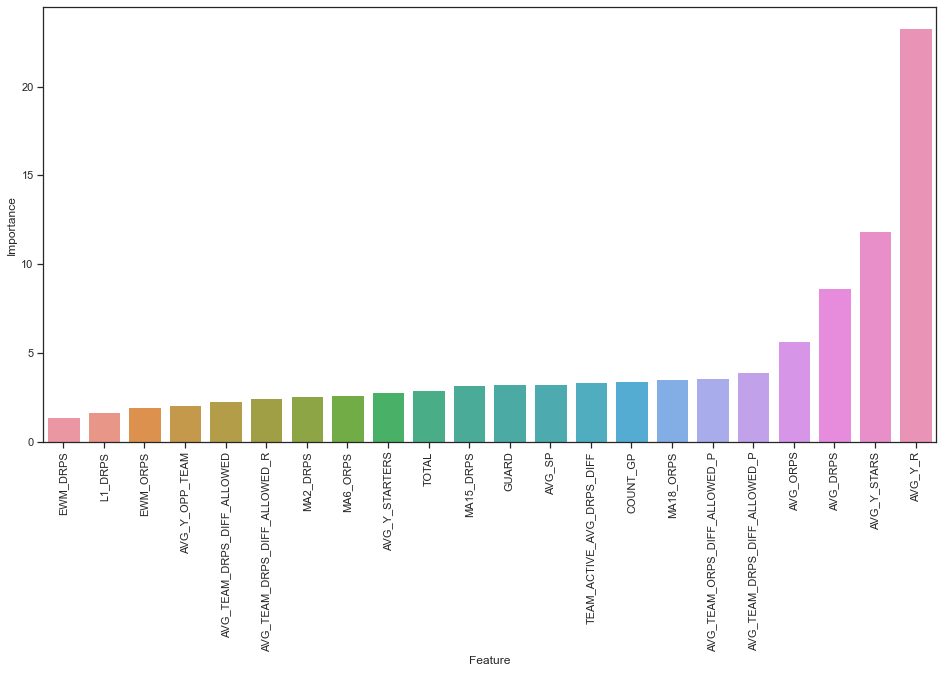

In [61]:
feature_importances = model.feature_importances_
feature_importance_df = pd.DataFrame({'Importance': feature_importances, 'Feature': selected_features})
feature_importance_df = feature_importance_df.sort_values(by='Importance')
ax = sns.barplot(x="Feature", y="Importance", data=feature_importance_df)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.show()

I will calculate a few metrics to evaluate the model's predictive power.

In [62]:
y_avg = feature_matrix.loc[X_test.index, 'AVG_Y']

# Kpi
print("R2 (explained variance):")
print("Model:", round(metrics.r2_score(y_test, y_hat, sample_weight=w_test), 3))
print("Baseline:", round(metrics.r2_score(y_test, y_avg, sample_weight=w_test), 3))

print("\nMean Absolute Error (Σ|y-pred|/n):")
print("Model:", round(metrics.mean_absolute_error(y_test, y_hat, sample_weight=w_test), 6))
print("Baseline:", round(metrics.mean_absolute_error(y_test, y_avg, sample_weight=w_test), 6))

print("\nRoot Mean Squared Error (sqrt(Σ(y-pred)^2/n)):")
print("Model:", round(np.sqrt(metrics.mean_squared_error(y_test, y_hat, sample_weight=w_test)), 6))
print("Baseline:", round(np.sqrt(metrics.mean_squared_error(y_test, y_avg, sample_weight=w_test)), 6))

R2 (explained variance):
Model: 0.448
Baseline: 0.435

Mean Absolute Error (Σ|y-pred|/n):
Model: 0.001165
Baseline: 0.001177

Root Mean Squared Error (sqrt(Σ(y-pred)^2/n)):
Model: 0.001529
Baseline: 0.001547


Residual analysis:

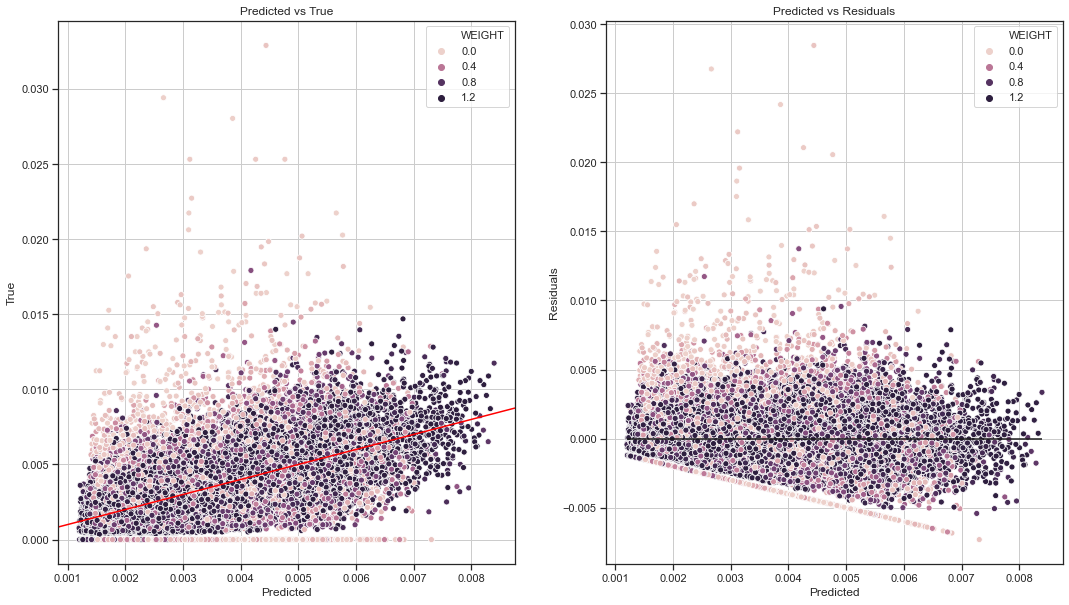

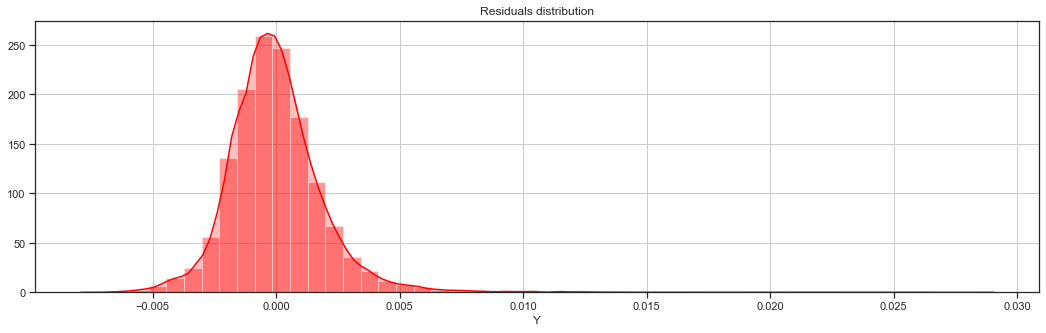

In [63]:
residuals = y_test - y_hat

# plot predicted vs true
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 10))
sns.scatterplot(y_hat, y_test, hue=w_test, ax=ax[0])
abline_plot(intercept=0, slope=1, color="red", ax=ax[0])
ax[0].grid(True)
ax[0].set(xlabel="Predicted", ylabel="True", title="Predicted vs True")
ax[0].legend()
    
# plot predicted vs residuals
sns.scatterplot(y_hat, residuals, hue=w_test, ax=ax[1])
ax[1].grid(True)
ax[1].set(xlabel="Predicted", ylabel="Residuals", title="Predicted vs Residuals")
ax[1].hlines(y=0, xmin=np.min(y_hat), xmax=np.max(y_hat))
ax[1].legend()
plt.show()

fig, ax = plt.subplots(figsize=(18, 5))
sns.distplot(residuals, color="red", hist=True, kde=True, kde_kws={"shade":True}, ax=ax)
ax.grid(True)
ax.set(title="Residuals distribution")
plt.show()

In [64]:
stat, p = shapiro(residuals)
print(stat, p)

0.9289669990539551 0.0


Residuals are normally distributed and not heteroskedastic.